In [1]:
%matplotlib inline

## Adjustment tolerances, material uncertainties, complex mathematical models, and noisy data - my strategy to decompose the measured signal into (i) individual error sources and (ii) measurement output of a high tech microscope.
copyright: Martin van Driel (Martin@vanDriel.de), 2021

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import grad, jit
from scipy.optimize import minimize

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 300

### Inputs

In [3]:
# spatial sampling of the object
dx = 35e-9

# wavelength
lambd = 500e-9

# numerical aperture
NA = 0.8

magnification = 1000

# the object: a comb with 5 smooth peaks of different amplitude
nsample = 200
true_obj = np.zeros(nsample)
true_obj[[80, 140]] = 1.1
true_obj[[100, 120]] = 0.9
true_obj[[160]] = 1.05
true_obj = np.convolve(true_obj, np.hanning(20) ** 3, mode='same')

# number of images taken
nimage = 10

# shift between experiments in mikro m
dshift = 0.1
shift_uncertainy = 0.01

# true aberrations, exclude P0 (no effect on intensity) and P1 (shift trades of
# with the shift of the images, so we can't resolve it)
true_P2 = 0.02
true_P3 = 0.05

# noise level
noise_level = 0.005

# for reproducibility seed the random generator
np.random.seed(123)

## A 'complex' mathematical model: an imaging function

Here we use a simplified imaging function in 1D assuming we can model the electric field as a scalar field and ignore polarization. The imaging is then described by the following equation, inspired by chapters 2 and 3 in [1]:

$$
\begin{align*}
    I &= | \mathcal{F}^{-1}( \mathcal{F}[E_i(x) t(x - s)] P(f_x) )| ^ 2 + N
\end{align*}
$$

where 
 - $I$ is the image,
 - $\mathcal{F}$ denotes the Fourier transform, 
 - $E_i = 1$ is the incoming electric field,
 - $x$ is the space coordinate in object space, 
 - $f_x$ the corresponding spatial frequency,
 - $t$ is the transmittance of the object, 
 - $s$ is a lateral shift of the object
 - $P$ is the pupil function,
 - $N$ is noise,
 
and the pupil function includes lens aberrations

$$
\begin{align*}
    P(f_x) &= P_\text{ideal}(f_x) \exp^{2\pi i W(f_x)} \\
    P_\text{ideal}(f_x) &= 
        \begin{cases}
            1, \qquad |f_x| < \frac{\text{NA}}{\lambda} \\
            0, \qquad \text{else}
        \end{cases} \\
    W(f_x) &= \sum_i P_i p_i\left(f_x \frac{\lambda}{\text{NA}}\right)
\end{align*}
$$

where
 - $W$ is the phase error at the exit pupil
 - $\text{NA}$ is the numerical aperture,
 - $\lambda$ is the wavelength
 - $P_i$ are the aberration coefficients
 - $p_i$ are Legendre polynomials
 
 [1] Fundamental Principles of Optical Lithography: The Science of Microfabrication, Chris Mack

In [4]:
@jit
def image(obj, P0=0., P1=0., P2=0., P3=0., NA=0.8, dx=10e-9, lambd=500e-9):
    """
    A mathematical model of the imaging process.

    obj: the object to be imaged in terms of scalar electrical field
    PN: aberation coefficients
    NA: numerical aperture
    dx: spatial sampling distance on the object side
    lambd: optical wavelength
    """

    # spatial frequencies fx
    fx = jnp.fft.fftfreq(nsample, dx)

    # wavefront aberration model W based on Legendre polynomials
    x = fx * lambd / NA
    W = (P0 +
         P1 * x +
         P2 / 2 * (3 * x ** 2 - 1) +
         P3 / 2 * (5 * x ** 3 -  3 * x)
        )

    # Pupil function P with aberrations included
    P = jnp.abs(fx) < NA / lambd
    P *= jnp.exp(2j * jnp.pi * W)

    # compute the image in spatial frequency space, fE
    # use complex fft, as we want to add phase shifts and the 
    # inverse transform may not result in a real valued field
    fE = jnp.fft.fft(obj)

    # multiply Pupil function P
    fE *= P

    # image I is the intensity of inverse FT
    I = jnp.abs(jnp.fft.ifft(fE)) ** 2

    return I


#### How do the individual components in this imaging function influence the image?

In [5]:
xobj = np.arange(nsample) * dx
ximage = np.arange(nsample) * dx * magnification

# A helper function for plotting
def new_axes():
    fig = plt.figure()
    ax1 = plt.gca()
    ax2 = ax1.twiny().twinx()
    
    ax1.set_xlabel('x object space / m')
    ax2.set_xlabel('x image space / m')
    ax1.set_ylabel('relative intensity in object space')
    ax2.set_ylabel('relative intensity in image space')
    
    fig.subplots_adjust(top=0.8)
    
    return ax1, ax2

def add_legends(ax1, ax2):
    if len(ax1.lines) > 0:
        ax1.legend(loc='upper left')
    if len(ax2.lines) > 0:
        ax2.legend(loc='upper right')


Influence of the wavelength with perfect lens

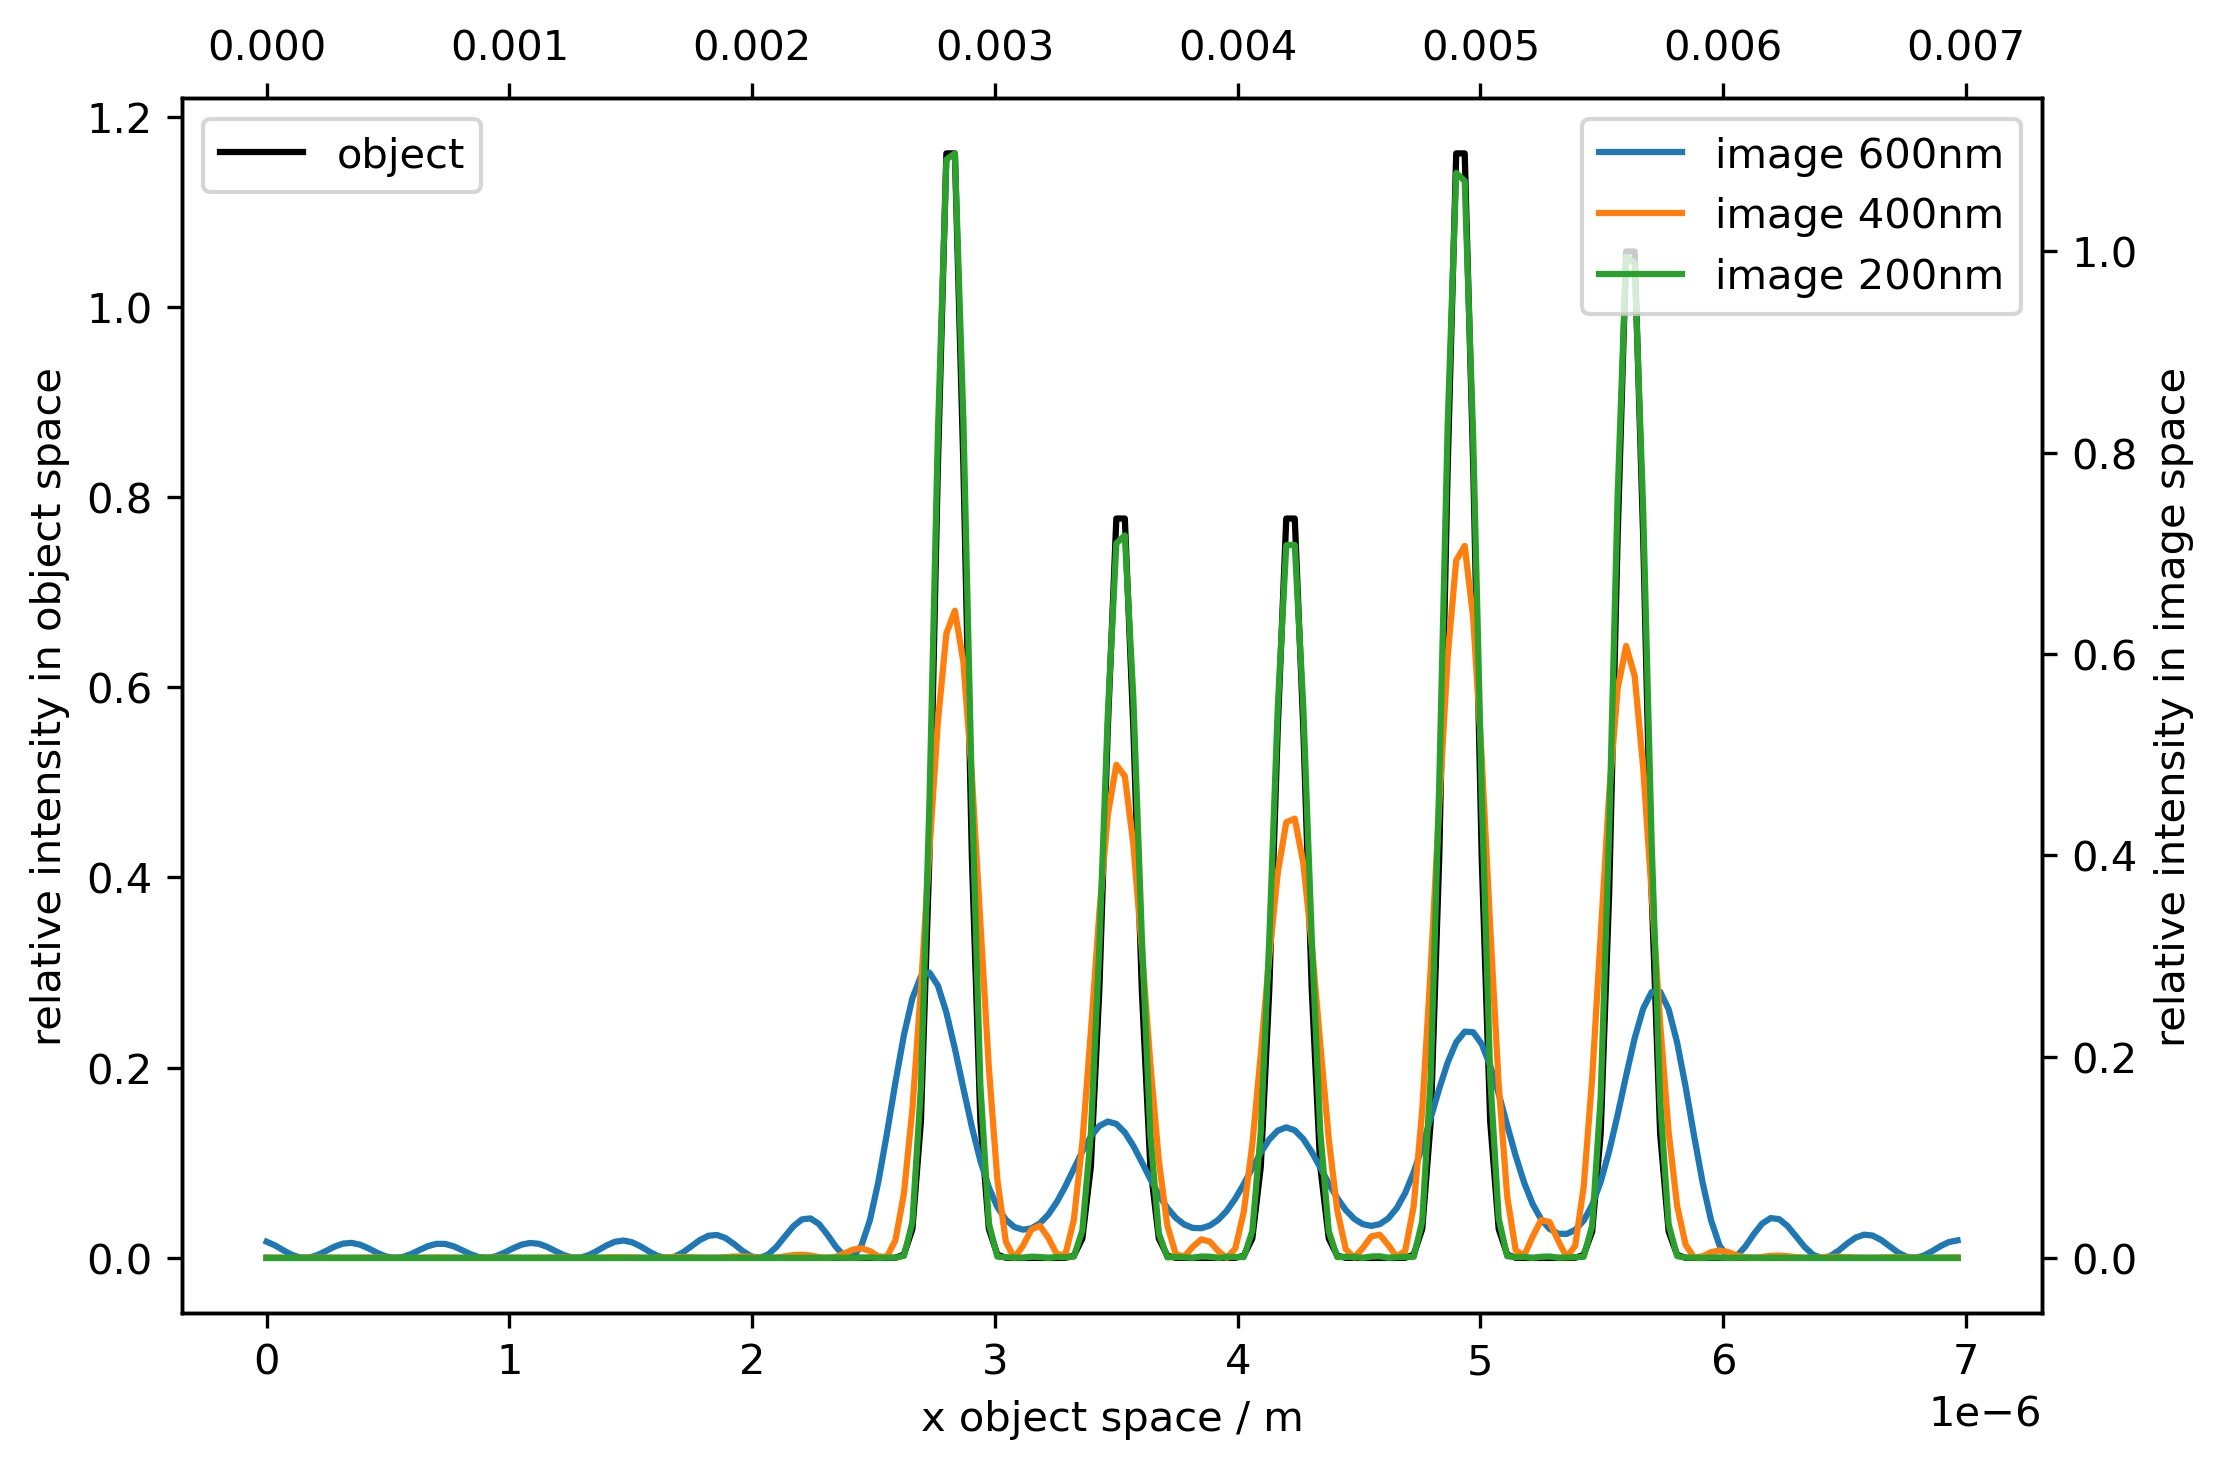

In [6]:
ax1, ax2 = new_axes()

ax1.plot(xobj, true_obj ** 2, color='k', label='object')
ax2.plot(ximage, image(true_obj, NA=NA, dx=dx, lambd=600e-9), 
         label='image 600nm')
ax2.plot(ximage, image(true_obj, NA=NA, dx=dx, lambd=400e-9), 
         label='image 400nm')
ax2.plot(ximage, image(true_obj, NA=NA, dx=dx, lambd=200e-9), 
         label='image 200nm')

add_legends(ax1, ax2)

Influence of the abberations at wavelength of 500nm: pont spread functions

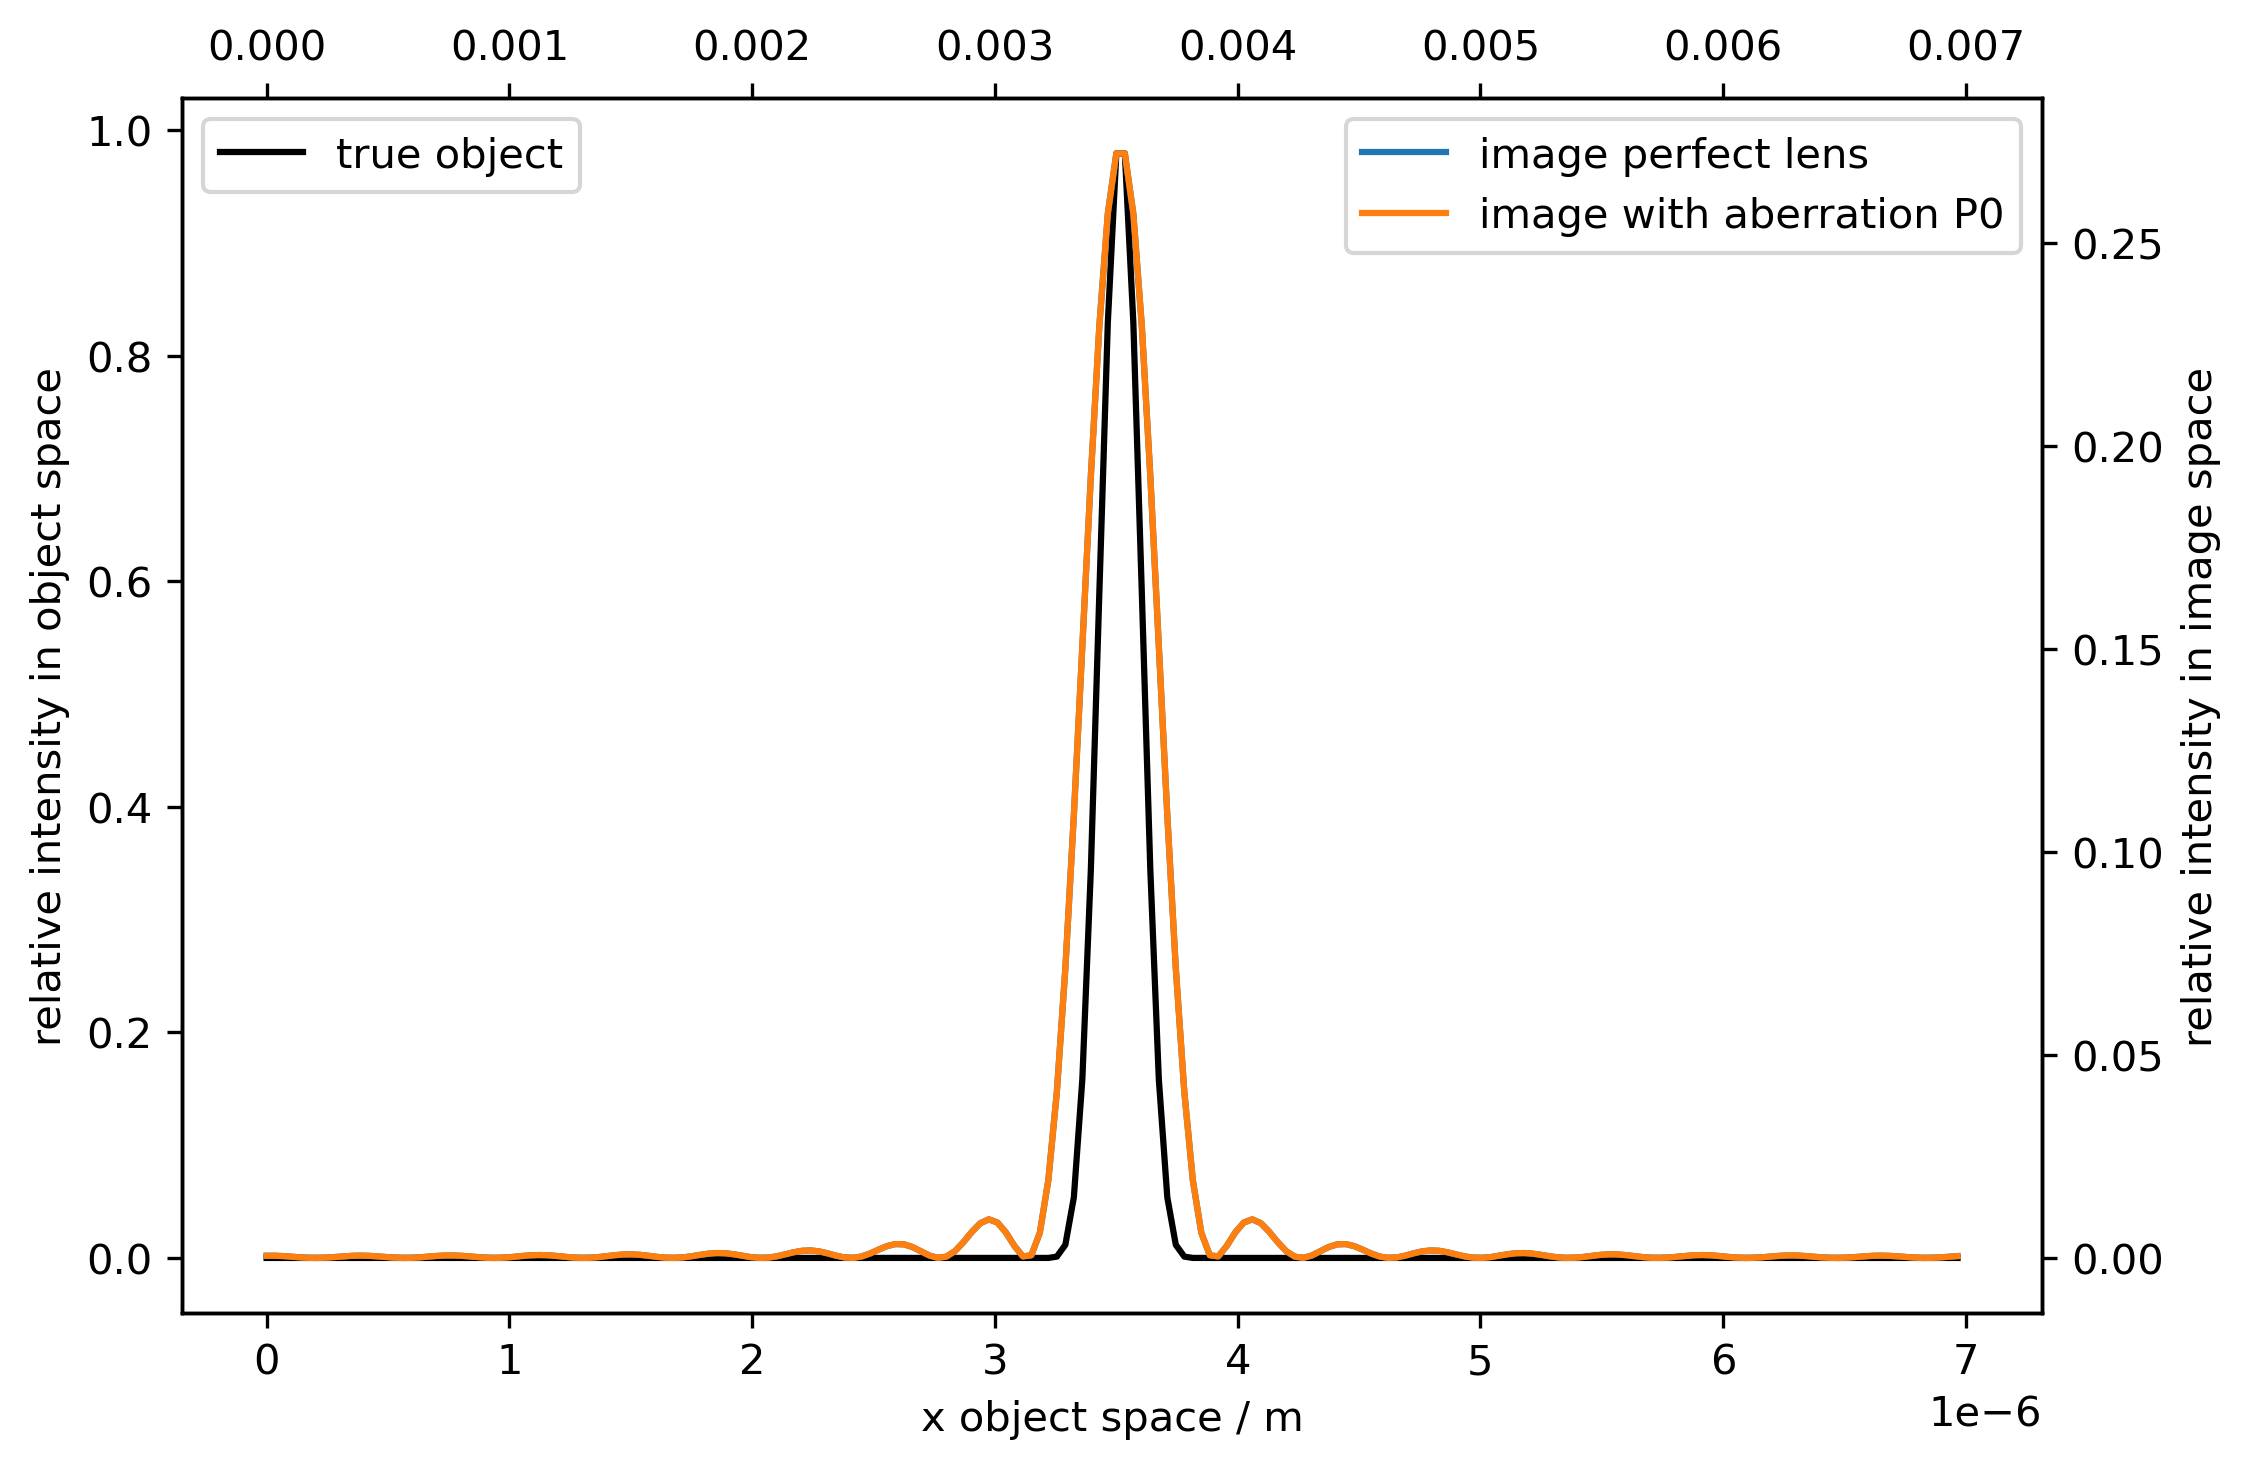

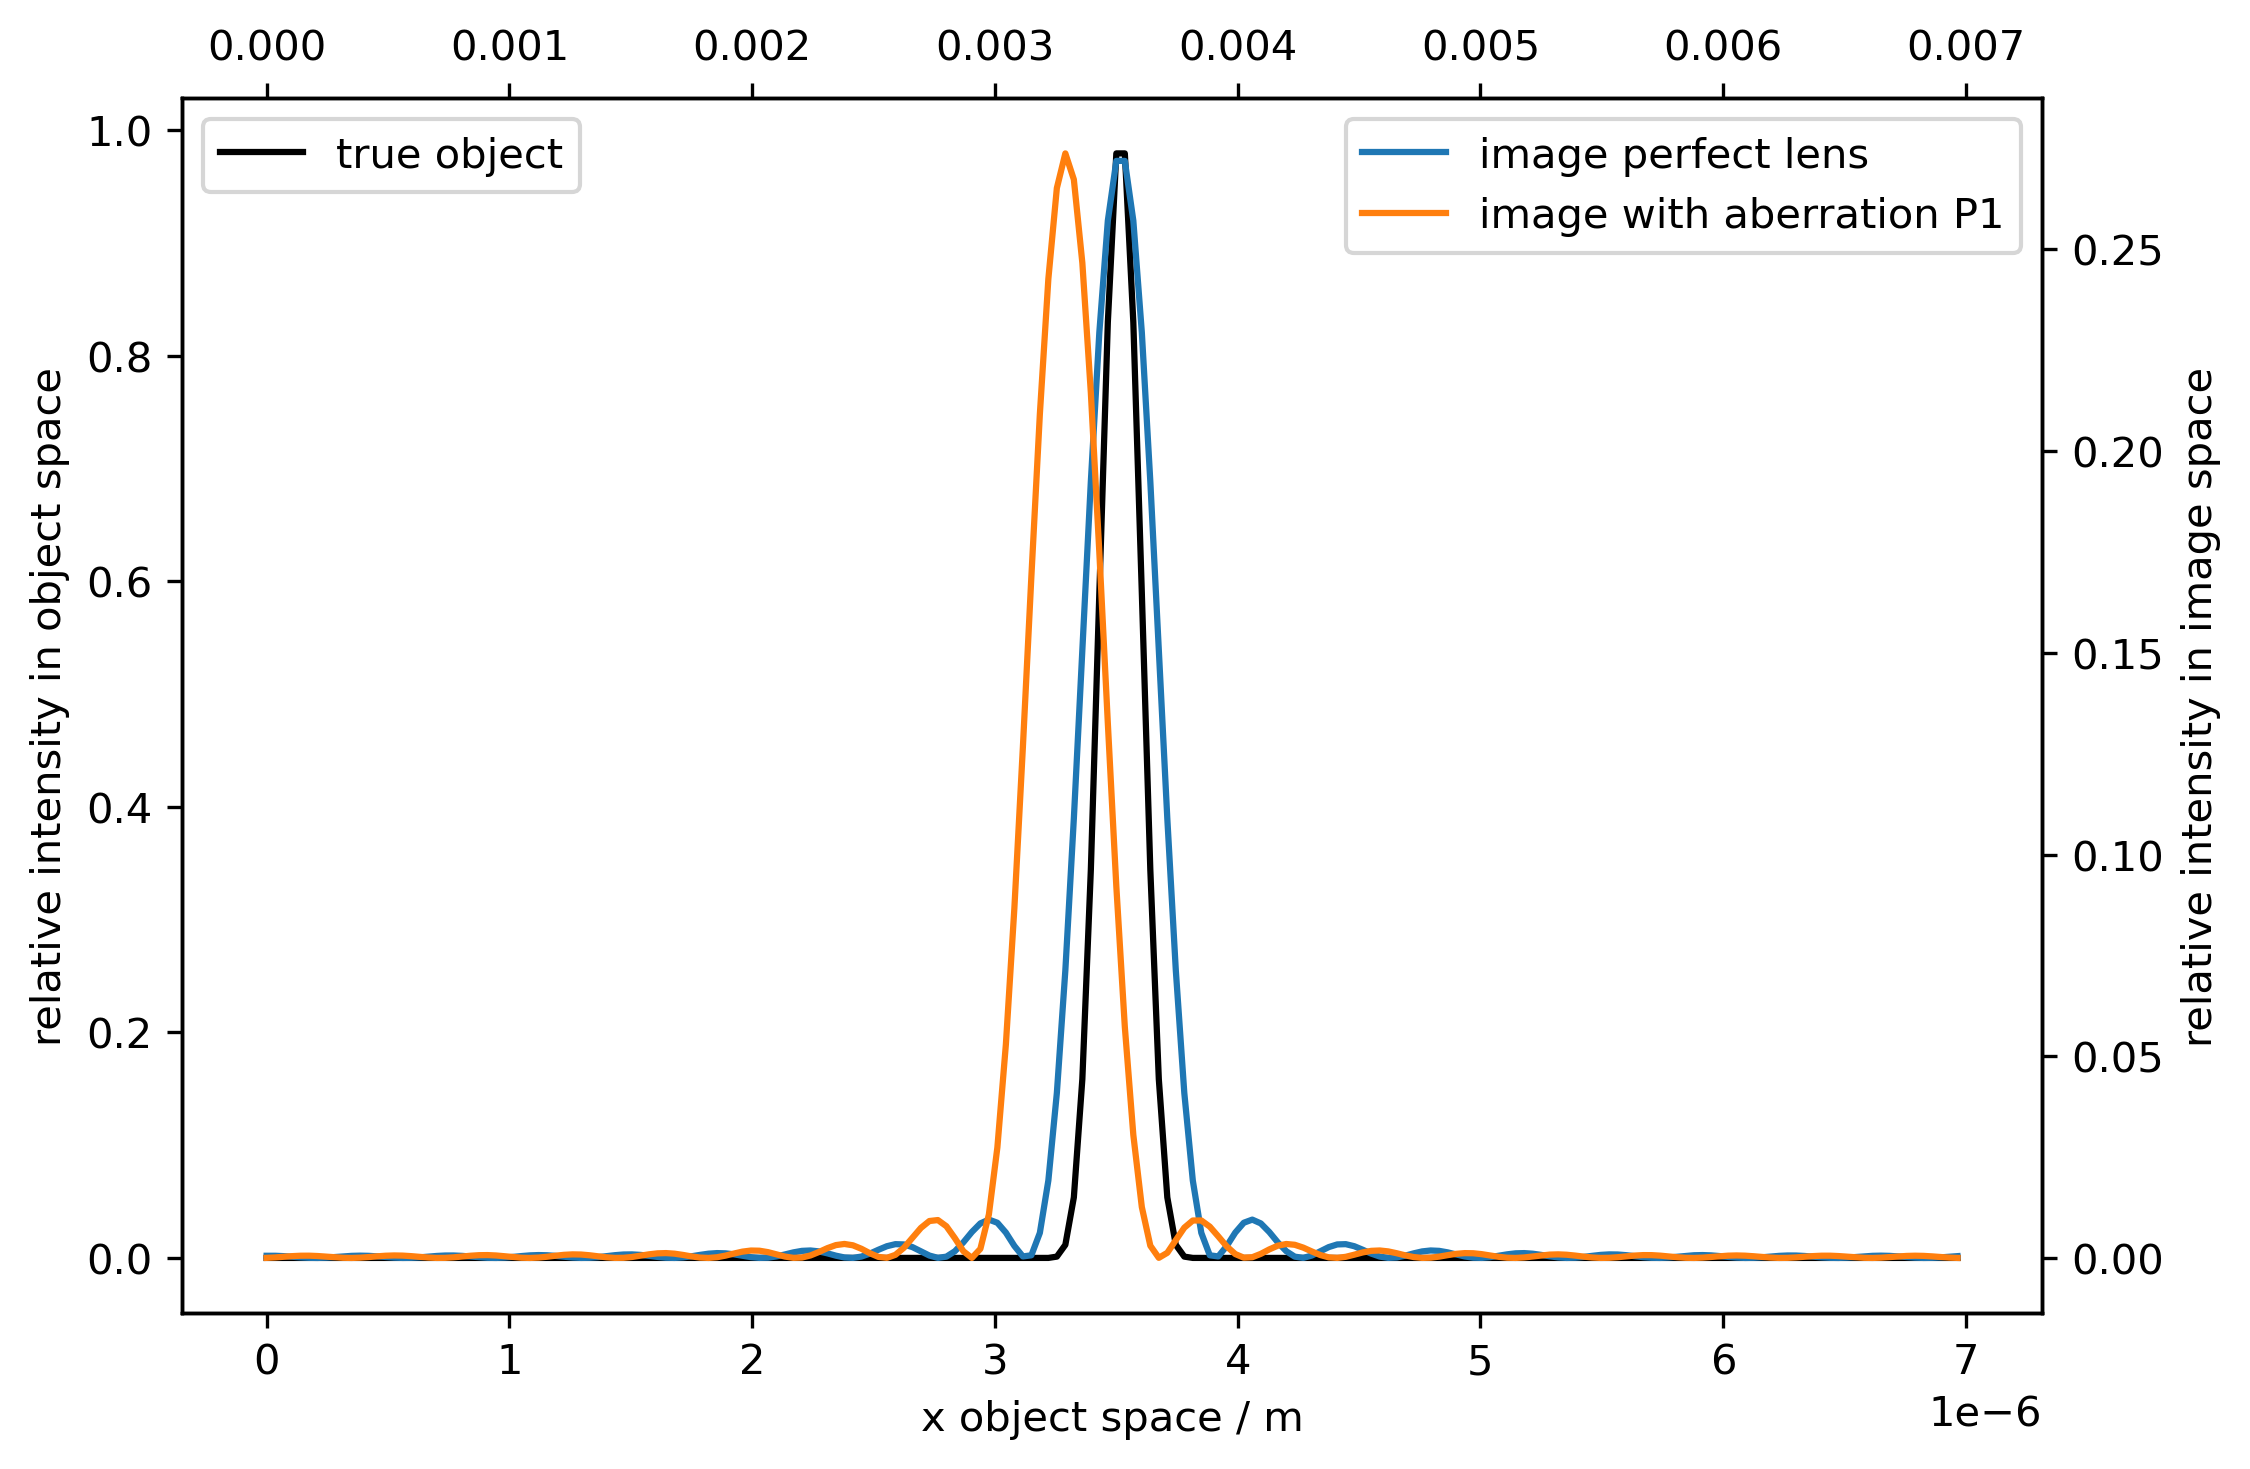

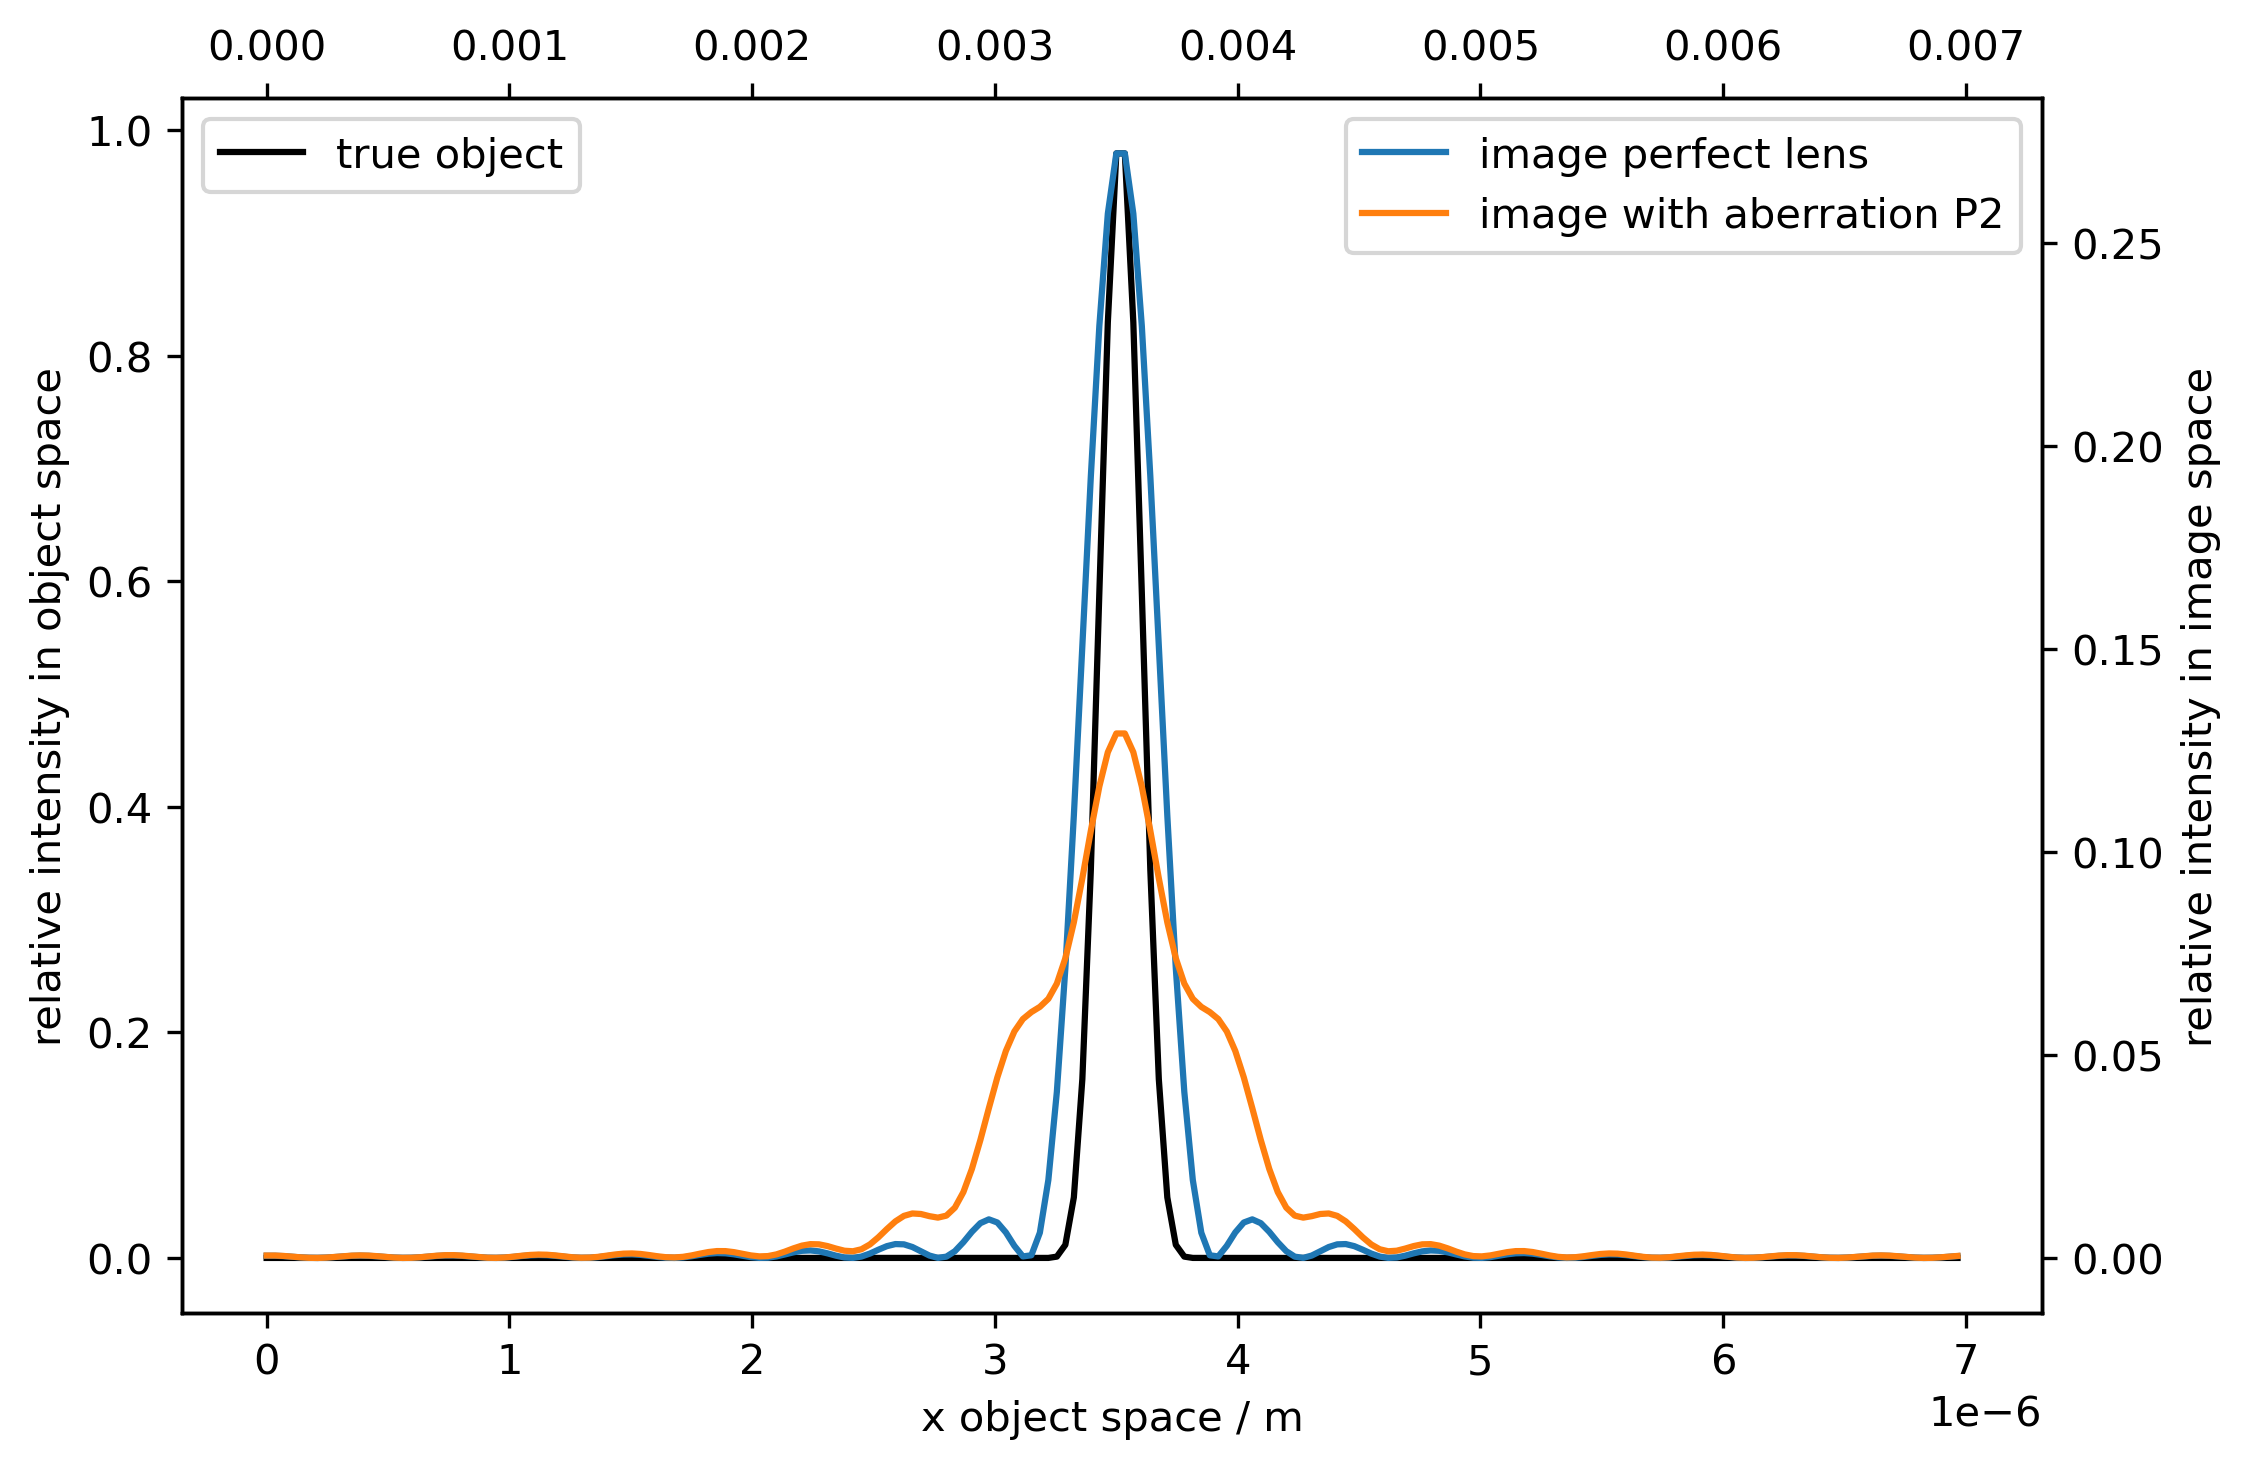

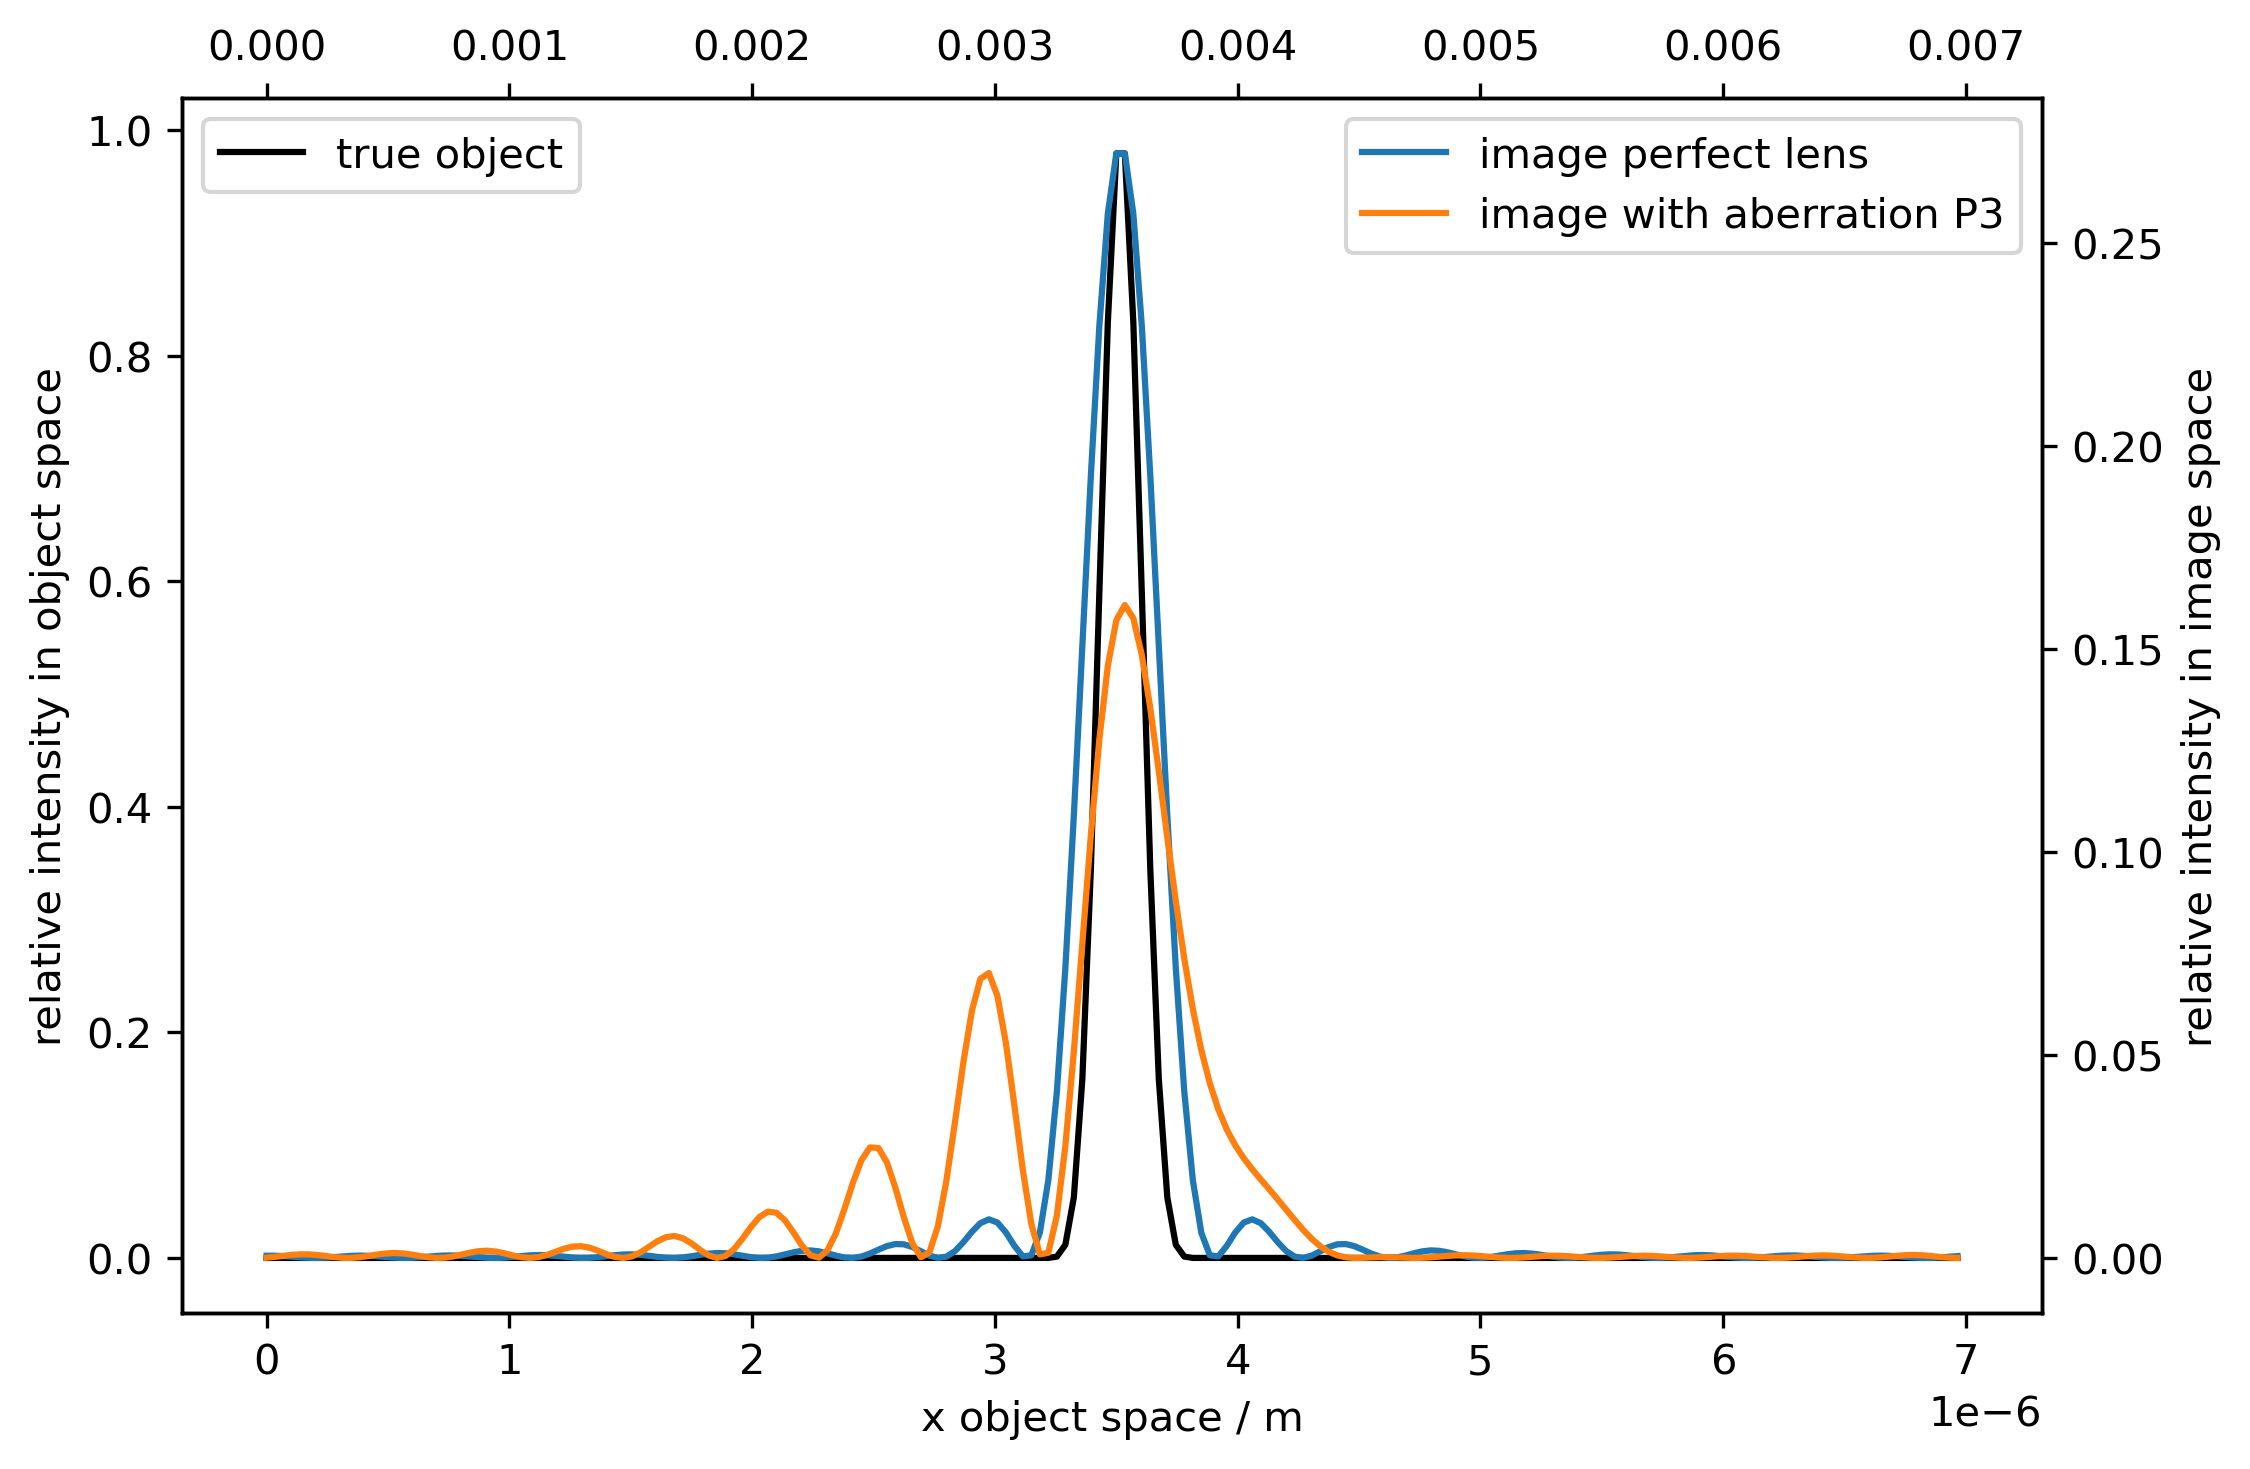

In [7]:
nsample = 200
psf_obj = np.zeros(nsample)
psf_obj[100] = 1.
psf_obj = np.convolve(psf_obj, np.hanning(20) ** 3, mode='same')


def plot_abberation(abbname):
    ax1, ax2 = new_axes()
    ax1.plot(xobj, psf_obj, label='true object', c='k')
    ax2.plot(ximage, image(psf_obj, NA=NA, dx=dx, lambd=600e-9), 
             label='image perfect lens')
    ax2.plot(ximage, image(psf_obj, NA=NA, dx=dx, lambd=600e-9, **{abbname: 0.3}), 
         label=f'image with aberration {abbname}')
    add_legends(ax1, ax2)


for i in range(4):
    plot_abberation(f'P{i}')



Lateral location of the object

In [8]:
@jit
def shift_object(obj, shift, dx):
    """
    Helper function to shift the object laterally in space with subsample
    resolution.
    """

    # spatial frequencies fx
    fx = jnp.fft.rfftfreq(len(obj), dx)

    # shift in frequency domain
    fobj = jnp.fft.rfft(obj)
    fobj *= jnp.exp(2j * jnp.pi * fx * shift)

    return jnp.fft.irfft(fobj)


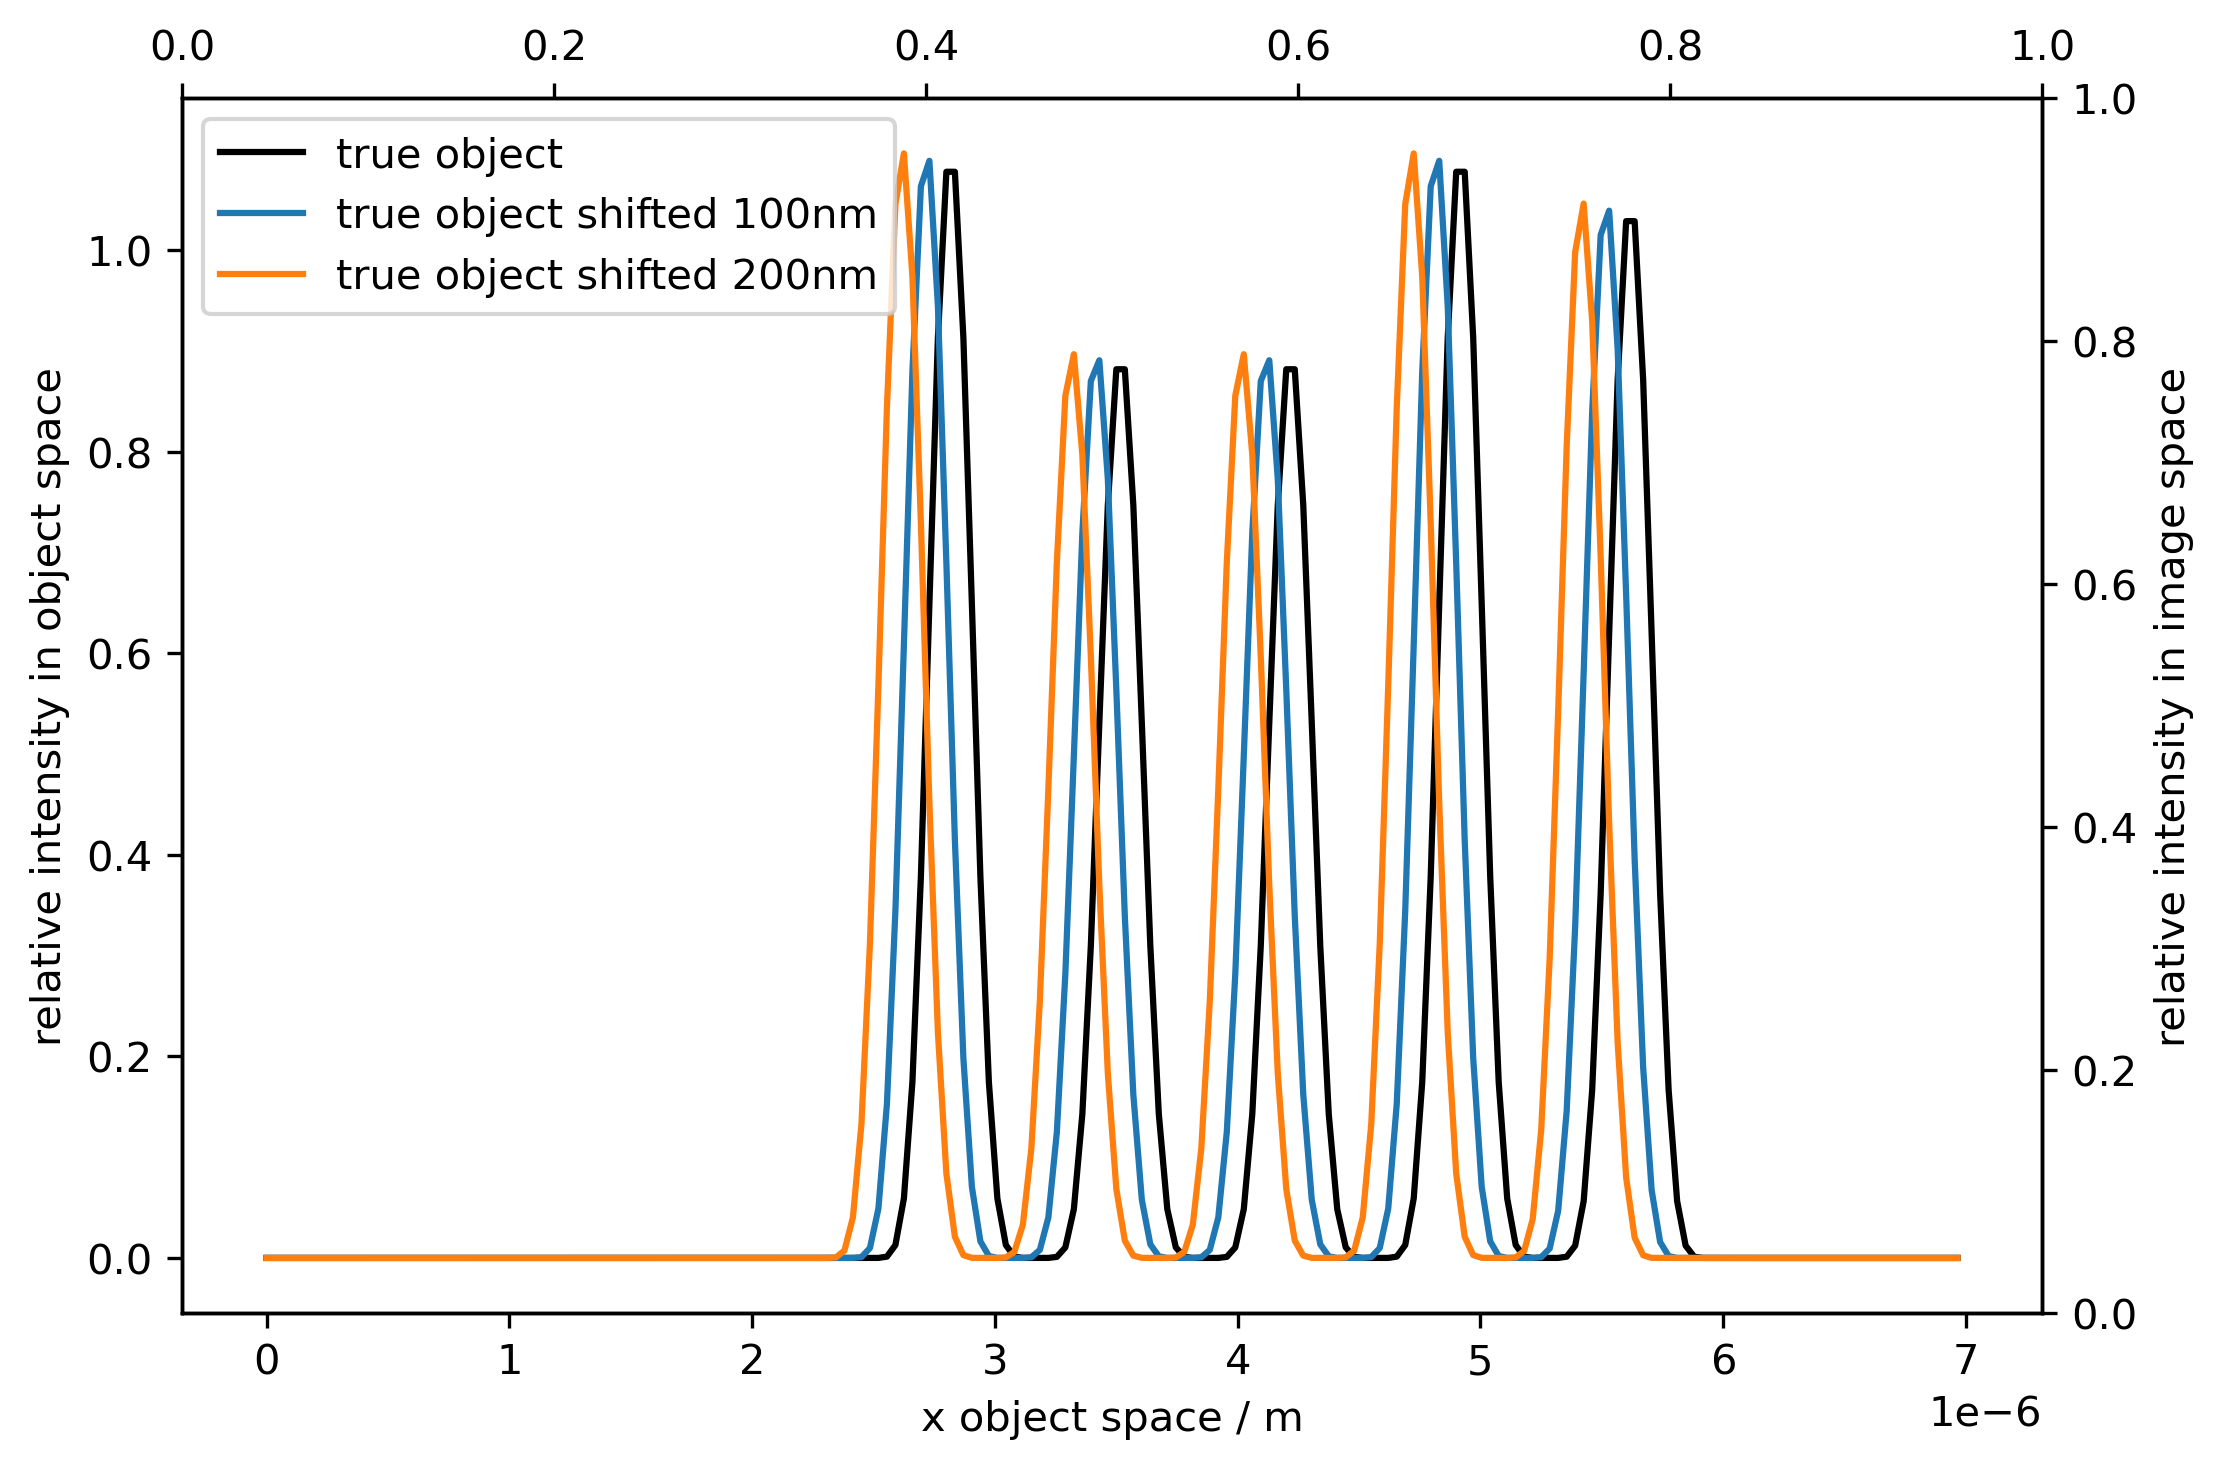

In [9]:
ax1, ax2 = new_axes()
ax1.plot(xobj, true_obj, label='true object', c='k')
ax1.plot(xobj, shift_object(true_obj, 1e-7, dx), label='true object shifted 100nm')
ax1.plot(xobj, shift_object(true_obj, 2e-7, dx), label='true object shifted 200nm')
add_legends(ax1, ax2)


## Setup an optimization framework

The goal is to to separate errors in lateral location, lens aberration and noise from the image and simultaneously improve the model of the object.

In [10]:
@jit
def forward(parameters, plot=False):
    """
    Wrapper function of the forward problem with multiple images, so that we
    have a function of a single variable with respect which we need to compute
    the gradient.
    """

    data = []
    P2, P3 = parameters[-2:]
    for i in range(nimage):
        obj = parameters[:nsample]
        shift = parameters[nsample+i] * 1e-6  # convert to m
        obj = shift_object(obj, shift, dx)
        data.append(image(obj, P2=P2, P3=P3, NA=NA, lambd=lambd, dx=dx))

        if plot:
            im = image(obj, P2=P2, P3=P3, NA=NA, lambd=lambd, dx=dx)
            im = shift_object(im, -shift, dx)
            plt.plot(im)
    return jnp.array(data).flatten()


Define a misfit/loss function to be optimized. Here we use the l2 norm in the image space, summed over all individual images. This is the simplest choice, but convergence radius may be small and a good starting model (in particular for the object) is needed. Regularization on the gradient of the model may help to keep a smooth representation of the object.

$$
\chi(m) = \sum_i |I(m_i) - I_{\text{obs}, i}|^2 + \alpha R(m)
$$

where

 - $m_i$ are the parameters (the model) for the i-th image
 - $I_{\text{obs}, i}$ is the i-th image
 - $\alpha$ is a regularization parameter
 - $R(m)$ is a regularization operator
 
The task then is to find

$$
\arg \min \chi(m)
$$

In [11]:
def loss(parameters, data, alpha=1e-5):
    """
    The loss function to be minimized
    """
    return jnp.sum((data - forward(parameters)) ** 2) \
            + alpha * jnp.sum(jnp.diff(parameters[:nsample]) ** 2)


### Jax provides automatic differentiation and just in time compilation

The numerically intense function above are all decorated with @jit to compile them using the XLA just in time compiler provided with jax. This added a few seconds of overhead in the startup, but lead to speed-up of the iterative solver by 1-2 orders of magnitude.

Jax also provides the autmatic differentiation framework, to compute the gradient of the loss function $\frac{\partial \chi}{\partial m}$ in a single line, this would otherwise require significant amounts of work:

In [12]:
# gradient of the loss function via autodiff
grad_loss = grad(loss)

def grad_loss_np(parameters, data):
    # scipy.minimize expects the jacobian as a numpy array of 64 bit float,
    # while jax returns 32 bit, so we need a wrapper just to cast the type
    return np.array(grad_loss(parameters, data), dtype=float)


To test the gradient, we need to prepare the the synthetic dataset...

In [13]:
# generate synthetic dataset, with some uncertainty on the true object location
true_shifts = np.arange(nimage) * dshift + np.random.randn(nimage) * shift_uncertainy
parameters = np.r_[true_obj, true_shifts, [true_P2, true_P3]]

data_nonoise = forward(parameters)
# add positive noise (data is intensity)
data = (data_nonoise ** 0.5 + np.random.randn(len(data_nonoise)) * noise_level) ** 2

In [14]:
# plotting only the first image
ax1, ax2 = new_axes()
ax2.plot(ximage, data_nonoise[:nsample], label='noise free data')
ax2.plot(ximage, data[:nsample], label='data')
add_legends(ax1, ax2)

 ...as well as the starting model parameters (model of the object, lateral locations and aberration coefficients) in a single array.

In [15]:
# starting model of the object for the optimization. Sensitive choice as the
# optimization may converge to a local minimum if this is to far from the true
# object. Here we use the scaled image produced by a perfect lens.
starting_obj = image(true_obj, NA=NA, lambd=lambd, dx=dx)
starting_obj /= starting_obj.max() / 1.2

# initial guess of the lateral shift between images and lens aberration
starting_shifts = np.arange(nimage) * dshift
starting_parameters = np.r_[starting_obj, starting_shifts, [0., 0.]]

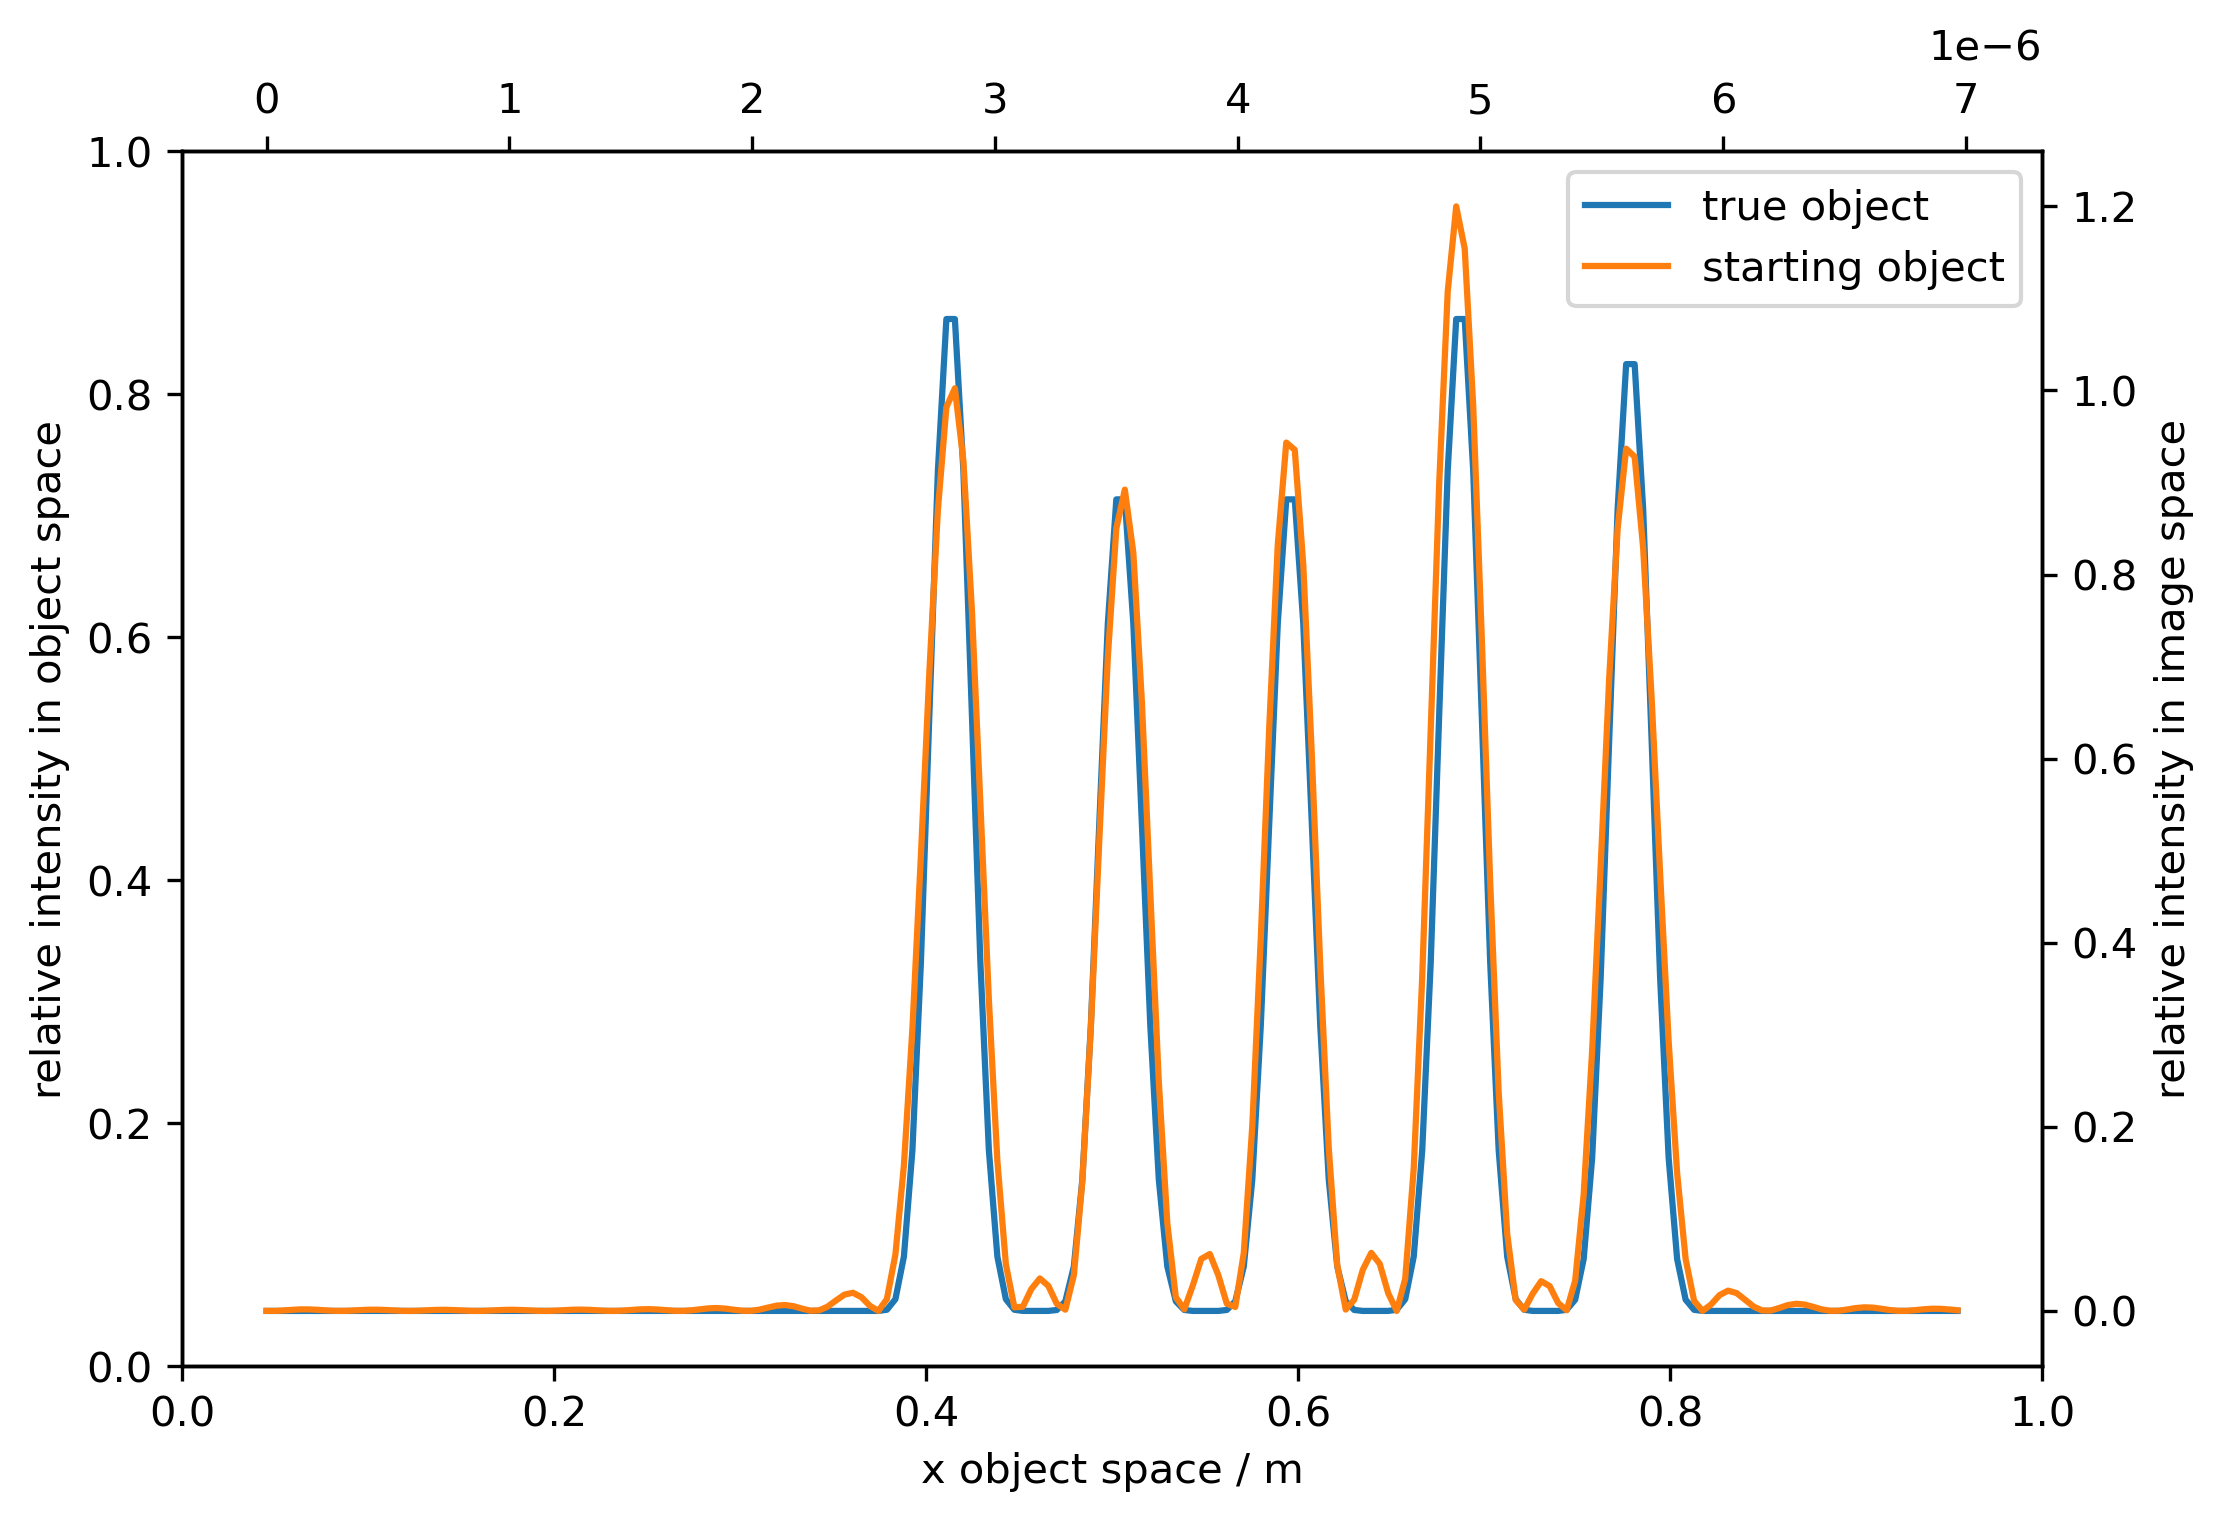

In [16]:
ax1, ax2 = new_axes()
ax2.plot(xobj, true_obj, label='true object')
ax2.plot(xobj, starting_obj, label='starting object')
add_legends(ax1, ax2)

Now we have all ingredients to test that gradient relative to a finite difference approximation in a random direction.

In [17]:
# a random perturbation of the parameter vector
dp = np.random.randn(nsample + nimage + 2) * 1e-4
print('finite differences: ', 
      loss(starting_parameters + dp / 2, data) -
      loss(starting_parameters - dp / 2, data))

# dot product of the gradient from autodiff with the perturbation vector
print('autodiff:           ', grad_loss(starting_parameters, data).dot(dp))

finite differences:  0.024866104
autodiff:            0.02485803


## The Optimization

Now we are ready to run the optimization, here we use a variant of the BFGS algorithm with low memory usage (L) and bound constraints (B). The latter are needed to confine the object to have only positive values, in other words the object only alters the amplitude of a plane wave incoming electric field (modelled as a scalar) but does not allow changes in the phase (a sign flip would be equivalent to a phase change of 180 degrees).

In [18]:
opt_result = minimize(loss, starting_parameters, args=(data,),
                      method='L-BFGS-B',
                      jac=grad_loss_np,
                      tol=1e-8,
                      bounds=[(0., None)] * nsample + [(None, None)] * (nimage + 2),
                      options={'iprint': 1})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          212     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25333D+00    |proj g|=  4.40675D+01

At iterate    1    f=  5.60724D+00    |proj g|=  1.22062D+01

At iterate    2    f=  5.16456D+00    |proj g|=  4.37140D+00

At iterate    3    f=  3.78962D+00    |proj g|=  1.21000D+01

At iterate    4    f=  2.04011D+00    |proj g|=  1.88110D+01

At iterate    5    f=  4.94070D-01    |proj g|=  5.11725D+00

At iterate    6    f=  3.33715D-01    |proj g|=  3.53196D+00

At iterate    7    f=  1.93030D-01    |proj g|=  4.95436D+00

At iterate    8    f=  1.54316D-01    |proj g|=  6.84078D+00

At iterate    9    f=  1.14088D-01    |proj g|=  1.37873D+00

At iterate   10    f=  1.10053D-01    |proj g|=  1.77371D-01

At iterate   11    f=  1.08607D-01    |proj g|=  3.82833D-01

At iterate   12    f=  1.04410D-01    |proj g|=  8.46574D-01

At iterate   13    f=  9.6


At iterate  138    f=  1.89222D-02    |proj g|=  1.75325D-02

At iterate  139    f=  1.89210D-02    |proj g|=  2.40216D-02

At iterate  140    f=  1.89189D-02    |proj g|=  1.41893D-02

At iterate  141    f=  1.89169D-02    |proj g|=  1.74726D-02

At iterate  142    f=  1.89135D-02    |proj g|=  2.37229D-02

At iterate  143    f=  1.89119D-02    |proj g|=  4.02983D-02

At iterate  144    f=  1.89094D-02    |proj g|=  2.13697D-02

At iterate  145    f=  1.89066D-02    |proj g|=  1.47211D-02

At iterate  146    f=  1.89046D-02    |proj g|=  2.17075D-02

At iterate  147    f=  1.89016D-02    |proj g|=  2.30550D-02

At iterate  148    f=  1.88994D-02    |proj g|=  2.51811D-02

At iterate  149    f=  1.88972D-02    |proj g|=  6.51871D-03

At iterate  150    f=  1.88954D-02    |proj g|=  1.73086D-02

At iterate  151    f=  1.88923D-02    |proj g|=  2.61572D-02

At iterate  152    f=  1.88883D-02    |proj g|=  2.47215D-02

At iterate  153    f=  1.88866D-02    |proj g|=  3.54413D-02

At iter


At iterate  276    f=  1.88115D-02    |proj g|=  7.10485D-03

At iterate  277    f=  1.88111D-02    |proj g|=  8.80296D-03

At iterate  278    f=  1.88107D-02    |proj g|=  1.31401D-02

At iterate  279    f=  1.88103D-02    |proj g|=  5.90105D-03

At iterate  280    f=  1.88100D-02    |proj g|=  6.08687D-03

At iterate  281    f=  1.88099D-02    |proj g|=  8.69574D-03

At iterate  282    f=  1.88093D-02    |proj g|=  8.67015D-03

At iterate  283    f=  1.88091D-02    |proj g|=  8.67596D-03

At iterate  284    f=  1.88088D-02    |proj g|=  4.90868D-03

At iterate  285    f=  1.88086D-02    |proj g|=  2.70192D-03

At iterate  286    f=  1.88085D-02    |proj g|=  3.22486D-03

At iterate  287    f=  1.88083D-02    |proj g|=  6.94510D-03

At iterate  288    f=  1.88081D-02    |proj g|=  9.55837D-03

At iterate  289    f=  1.88079D-02    |proj g|=  4.50129D-03

At iterate  290    f=  1.88077D-02    |proj g|=  4.80179D-03

At iterate  291    f=  1.88076D-02    |proj g|=  5.27766D-03

At iter


At iterate  409    f=  1.87620D-02    |proj g|=  6.32894D-03

At iterate  410    f=  1.87617D-02    |proj g|=  2.63523D-03

At iterate  411    f=  1.87615D-02    |proj g|=  2.73423D-03

At iterate  412    f=  1.87612D-02    |proj g|=  5.26258D-03

At iterate  413    f=  1.87610D-02    |proj g|=  9.45587D-03

At iterate  414    f=  1.87606D-02    |proj g|=  4.72092D-03

At iterate  415    f=  1.87603D-02    |proj g|=  5.60212D-03

At iterate  416    f=  1.87599D-02    |proj g|=  6.36353D-03

At iterate  417    f=  1.87595D-02    |proj g|=  1.71698D-02

At iterate  418    f=  1.87587D-02    |proj g|=  1.04325D-02

At iterate  419    f=  1.87584D-02    |proj g|=  4.00769D-03

At iterate  420    f=  1.87582D-02    |proj g|=  4.32396D-03

At iterate  421    f=  1.87580D-02    |proj g|=  4.87441D-03

At iterate  422    f=  1.87573D-02    |proj g|=  8.79604D-03

At iterate  423    f=  1.87566D-02    |proj g|=  1.14468D-02

At iterate  424    f=  1.87555D-02    |proj g|=  1.02521D-02

At iter

### Evaluation of the results
As we know the true parameters in this synthetic case, we can evaluate the results in relative to ground truth:

In [19]:
print('stdv of the location error before optimization: ',
      ((true_shifts - starting_shifts) ** 2).sum() ** 0.5)
print('stdv of the location error after  optimization: ',
      ((true_shifts - opt_result.x[nsample:nsample+nimage]) ** 2).sum() ** 0.5)
print()
print('initial P2               : ', starting_parameters[-2])
print('true P2                  : ', true_P2)
print('P2 obtained from the data: ', opt_result.x[-2])
print()
print('initial P3               : ', starting_parameters[-1])
print('true P3                  : ', true_P3)
print('P3 obtained from the data: ', opt_result.x[-1])

stdv of the location error before optimization:  0.04001360388586576
stdv of the location error after  optimization:  0.004049775390744365

initial P2               :  0.0
true P2                  :  0.02
P2 obtained from the data:  0.019570999395971542

initial P3               :  0.0
true P3                  :  0.05
P3 obtained from the data:  0.05268403235023853


In [20]:
ax1, ax2 = new_axes()
ax1.plot(xobj, true_obj, label='true object', c='k')
ax1.plot(xobj, starting_obj, label='starting object')
ax1.plot(xobj, opt_result.x[:nsample], label='optimized object')
add_legends(ax1, ax2)

(4.5e-06, 5.5e-06)

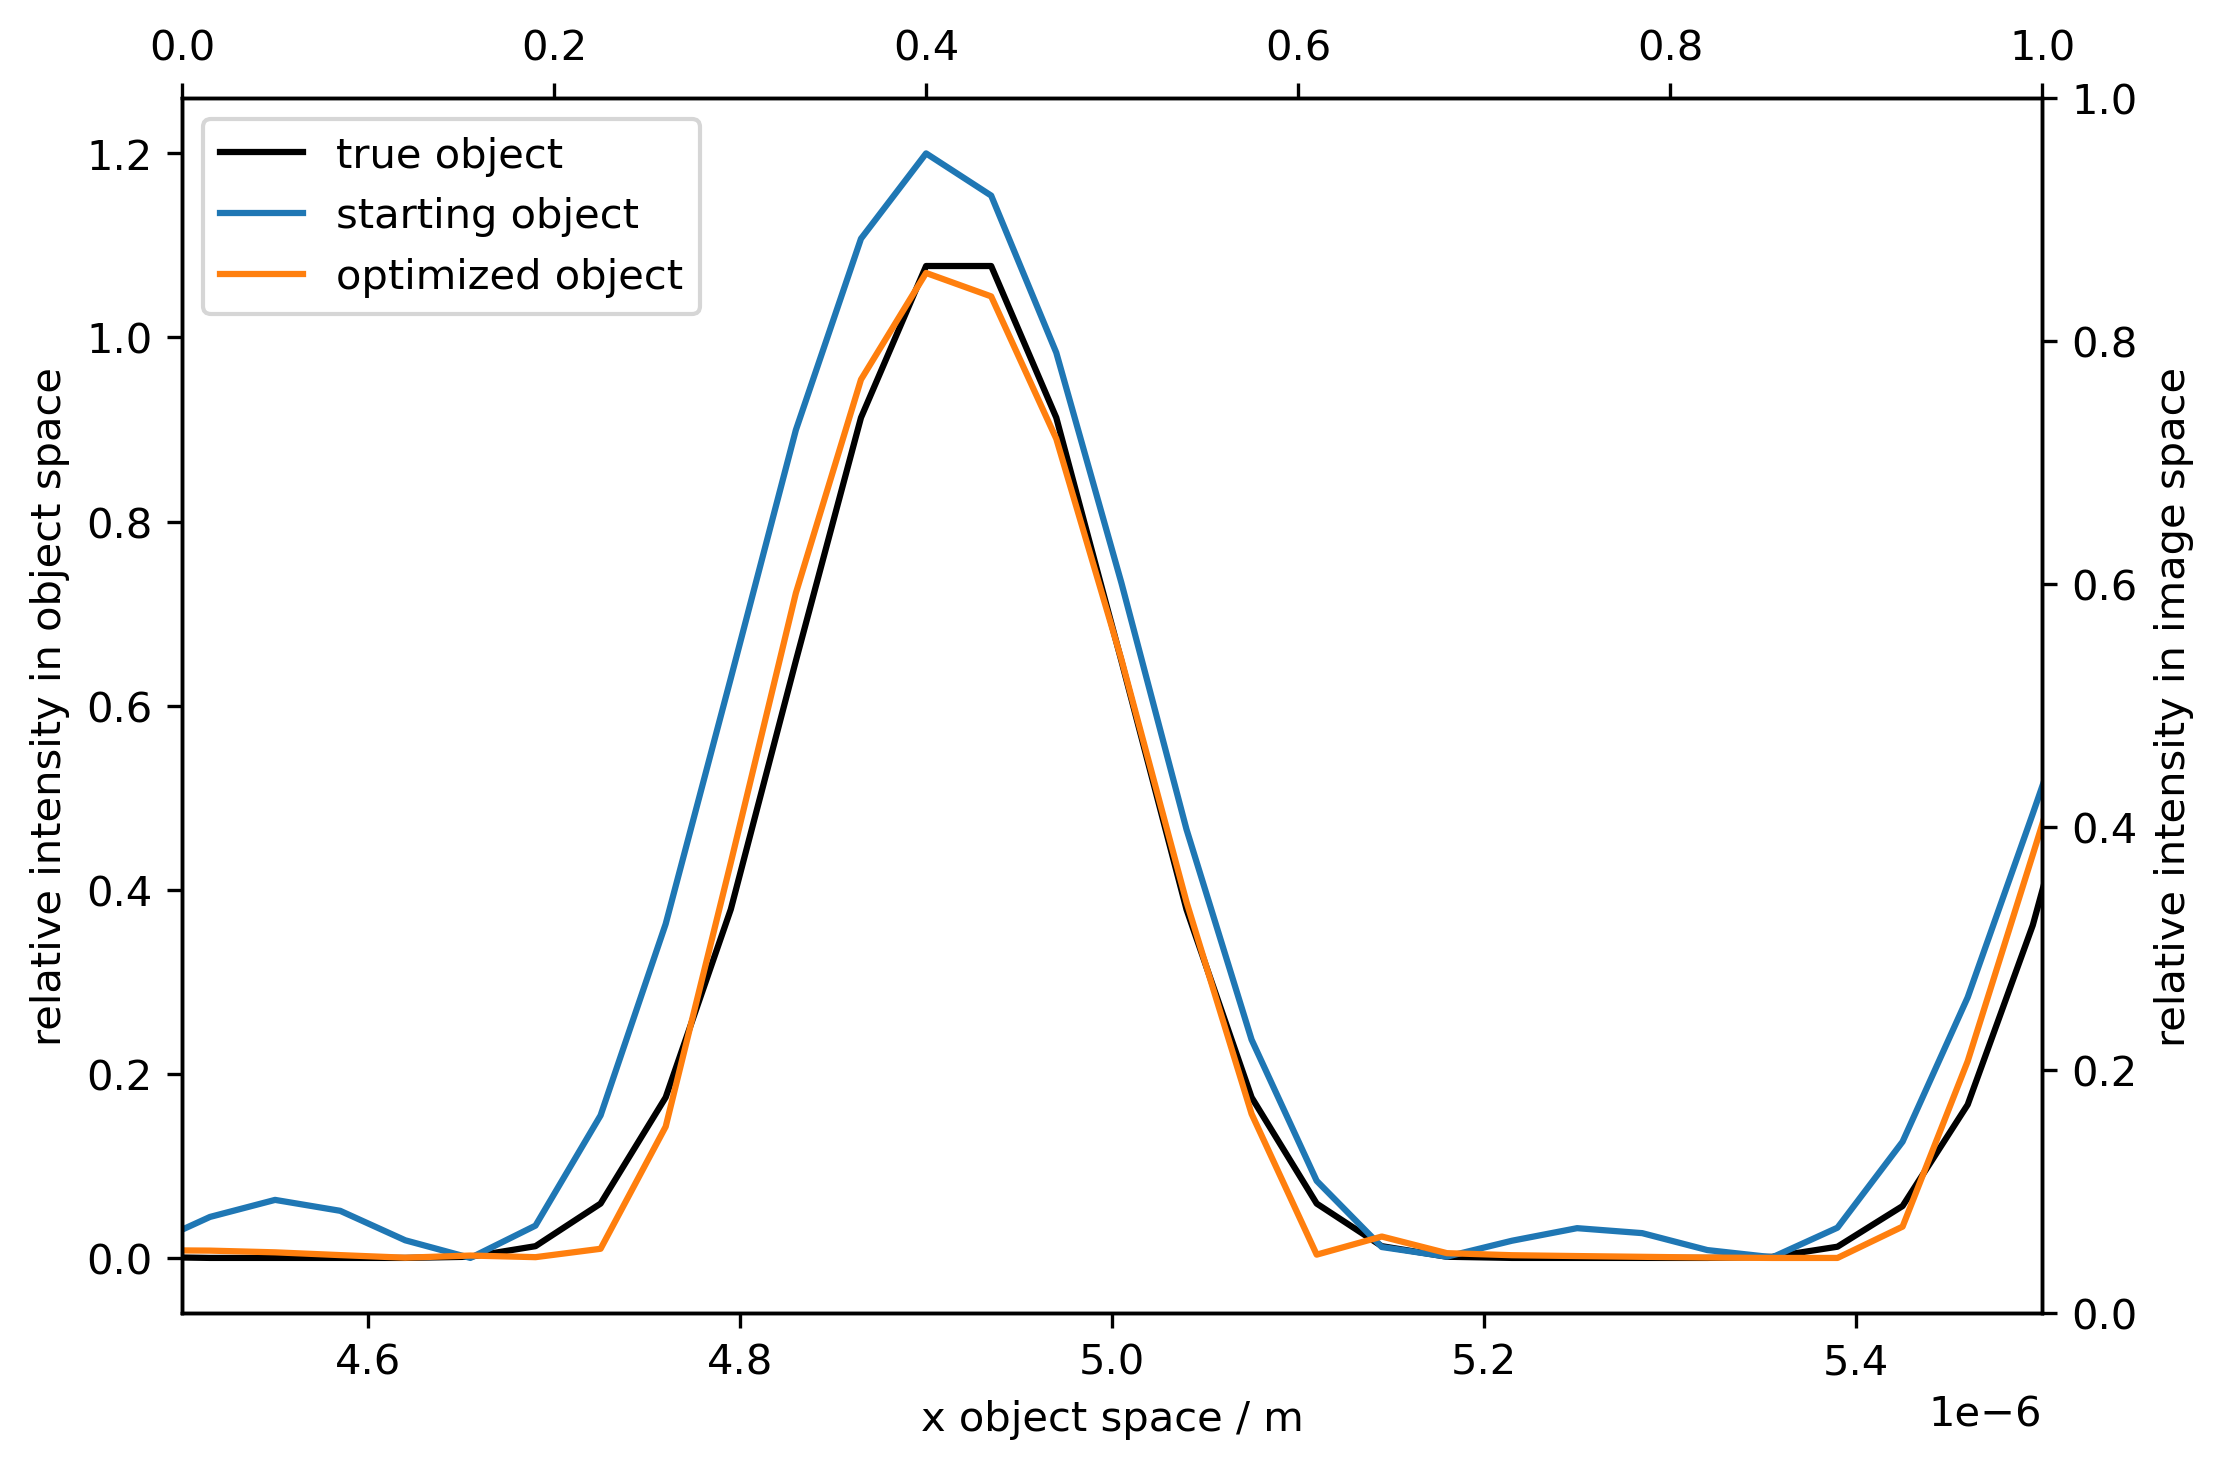

In [21]:
ax1, ax2 = new_axes()
ax1.plot(xobj, true_obj, label='true object', c='k')
ax1.plot(xobj, starting_obj, label='starting object')
ax1.plot(xobj, opt_result.x[:nsample], label='optimized object')
add_legends(ax1, ax2)
ax1.set_xlim(4.5e-6, 5.5e-6)

### Comparison in data space: separate noise from signal?

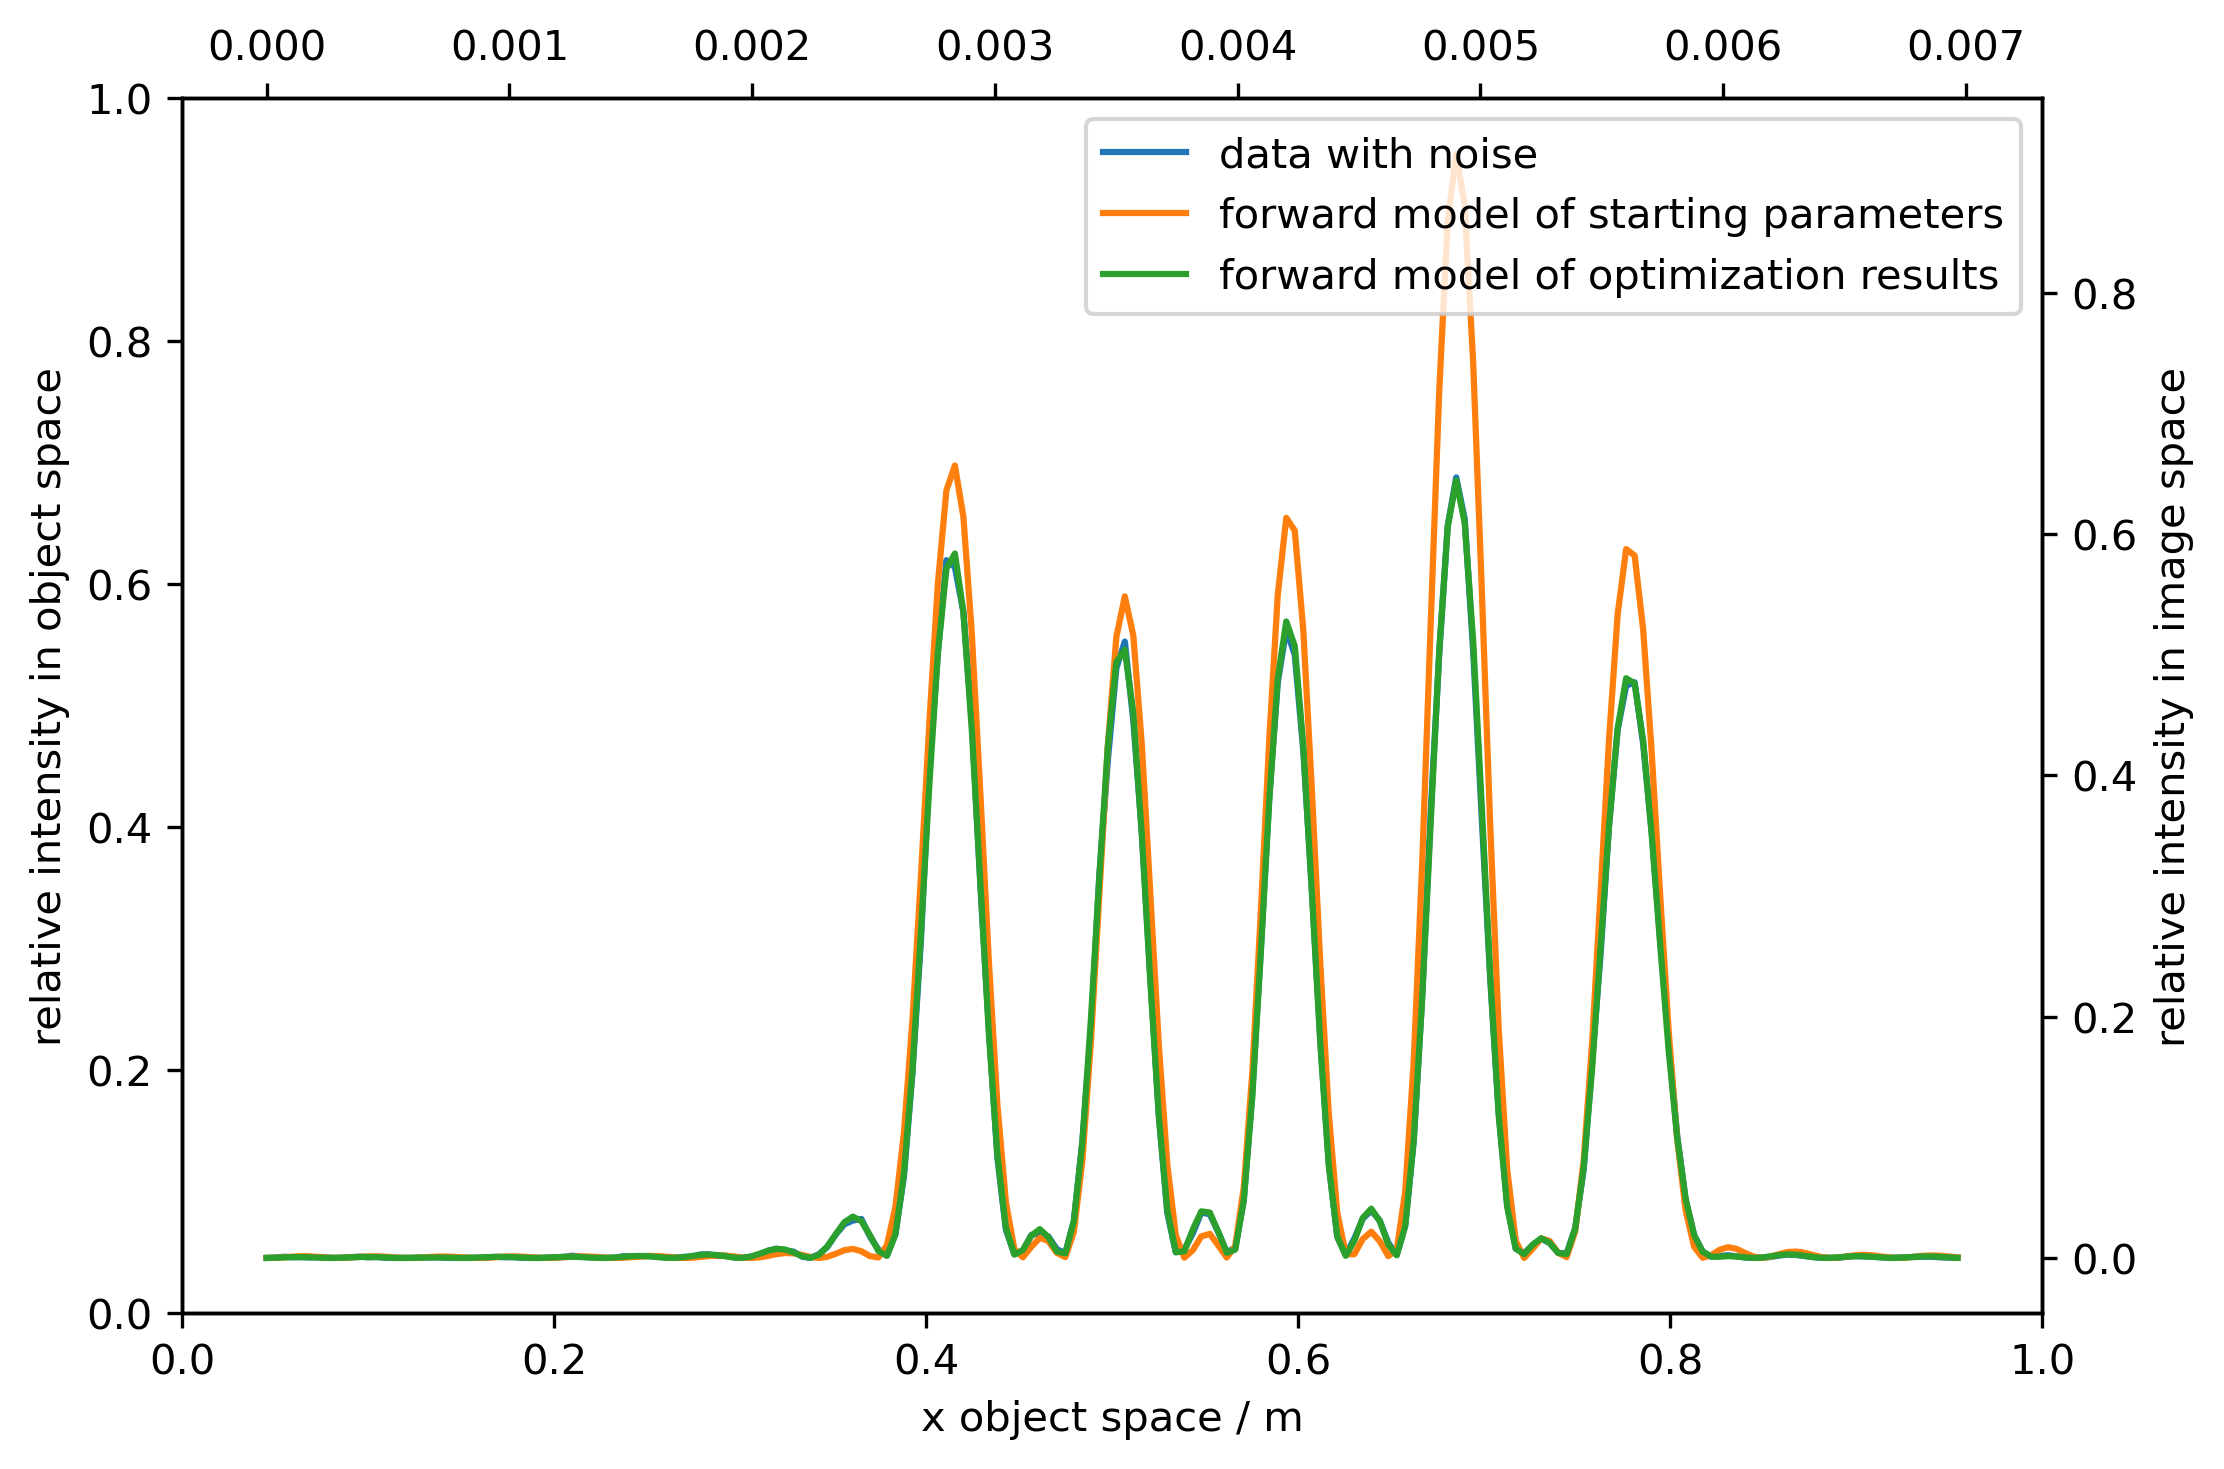

In [22]:
# only plot the first image
ax1, ax2 = new_axes()
ax2.plot(ximage, data[:nsample], label='data with noise')
ax2.plot(ximage, forward(starting_parameters)[:nsample], label='forward model of starting parameters')
ax2.plot(ximage, forward(opt_result.x)[:nsample], label='forward model of optimization results')
add_legends(ax1, ax2)

What about the noise?

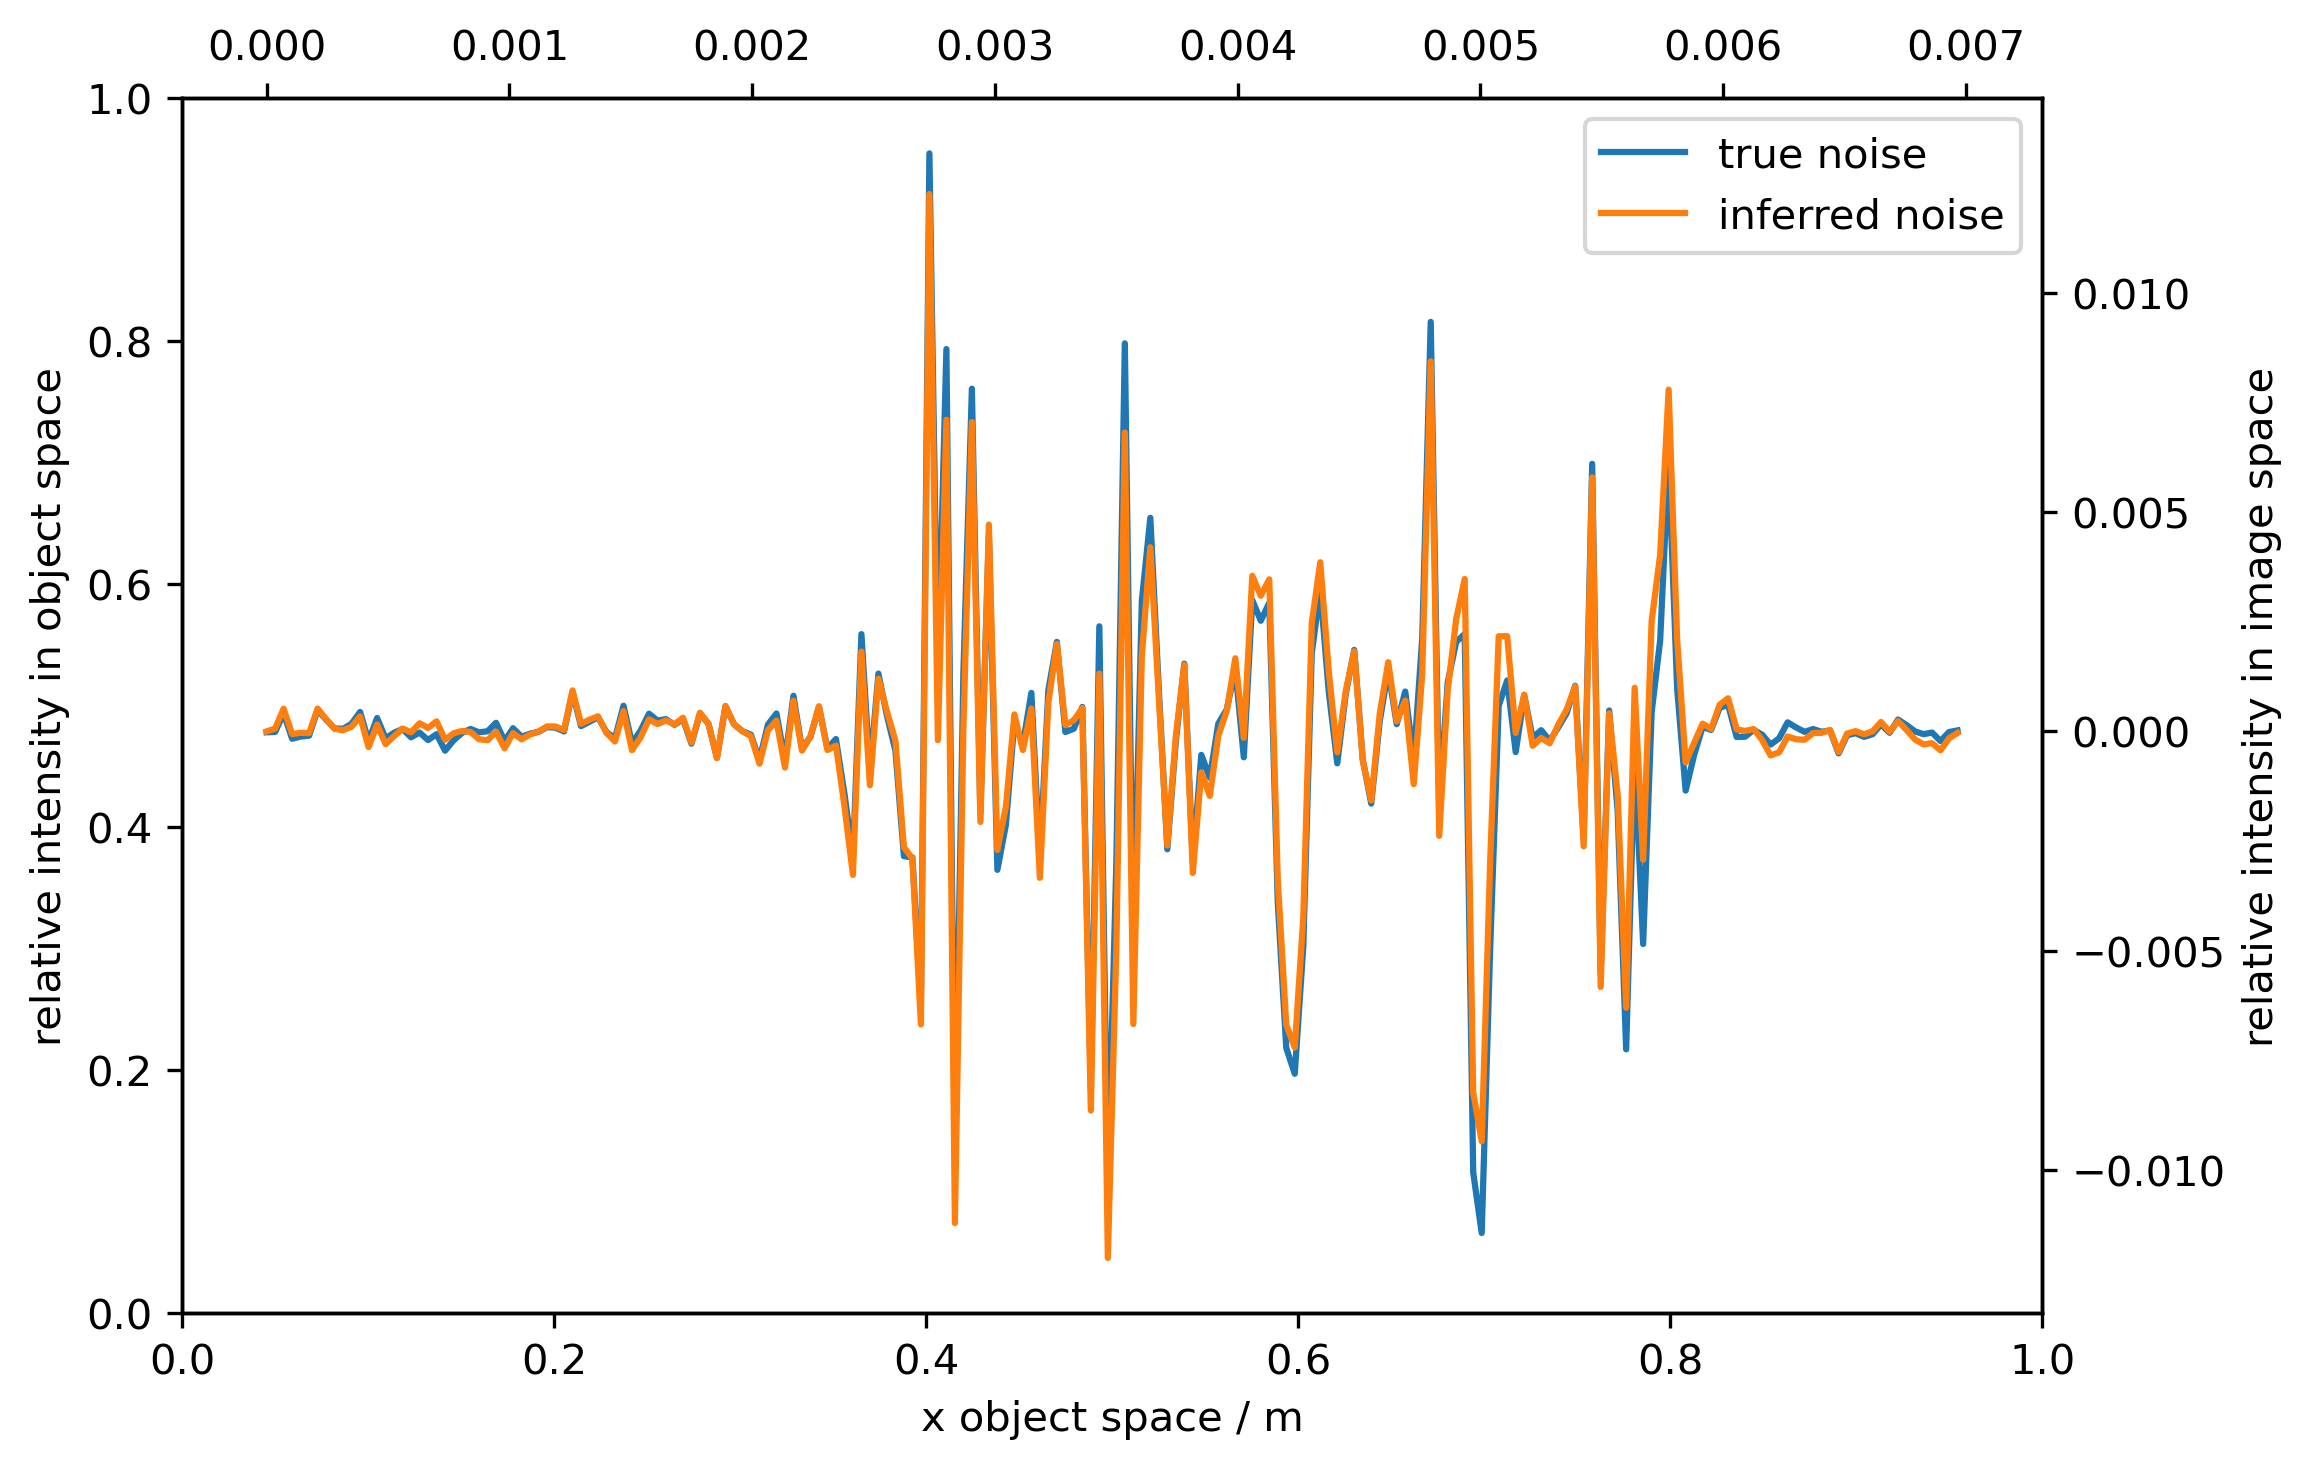

In [23]:
ax1, ax2 = new_axes()
ax2.plot(ximage, data[:nsample] - data_nonoise[:nsample], label='true noise')
ax2.plot(ximage, data[:nsample] - forward(opt_result.x)[:nsample], label='inferred noise')
add_legends(ax1, ax2)

In [24]:
ax1, ax2 = new_axes()
ax2.plot(ximage, data_nonoise[:nsample], label='noisefree data')
ax2.plot(ximage, forward(opt_result.x)[:nsample], label='forward model of optimization results')
add_legends(ax1, ax2)